# <center> **ПРОЕКТ №3. Предсказание рейтинга отеля с помощью Машинного Обучения**

В этом проекте нам необходимо обучить ML-модель, и добиться наибольшей точности предсказания рейтинга отеля, ориентируясь на информацию о нем, которую он указывает сам. Я собираюсь выполнить эту задачу с помощью Проектирования Признаков (*англ. Feature Engineering*). 

Все дело в том, что модель может обучаться только на числовых данных, а так как у нас есть данные также и в текстовом виде, их нужно исследовать на предмет полезной информации и преобразовать в числа. Это могут быть определенные показатели или категории, которые необходимо пронумеровать. Модель будет запоминать, что тому или иному числу соответствует другое число, и таким образом предсказывать нектоторый результат (если я правильно понимаю, как работает МО).

Выгружаю данный проект в открытый доступ. Смотрите, оценивайте, комментируйте ;)

---

## Импорт необходимых библиотек

Необходимо для работы с данными.

In [6]:
# для работы с файлами
import os

# для анализа и обработки данных
import numpy as np 
import pandas as pd 
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, BinaryEncoder

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# для обучения модели
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [7]:
# фиксация семени для воспроизводимости
RANDOM_SEED = 42

# фиксация версий пакетов
!pip freeze > requirements.txt

# ссылки на директории, в которых лежат данные
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


---

## Загрузка данных

У нас есть 3 CSV-файла: 
* `hotels_train` - для обучения модели.
* `hotels_test` - для оценки качества модели. 
* `submission` - для отпправки результатов на соревнование.

Первые 2 содержат следующие наборы признаков: 
* `hotel_address` (object) - адрес отеля.
* `additional_number_of_scoring` (int) - количество оценок без отзыва.
* `review_date` (object) - дата отзыва.
* `average_score` (float) - средний балл отеля.
* `hotel_name` (object) - название отеля.
* `reviewer_nationality` (object) - национальность рецензента.
* `negative_review` (object) - отрицательный отзыв.
* `review_total_negative_word_counts` (int) - количество слов в отрицательном отзыве.
* `total_number_of_reviews` (int) - количество отзывов вообще.
* `positive_review` (object) - положительный отзыв.
* `review_total_positive_word_counts` (int) - количество слов в положительном отзыве.
* `total_number_of_reviews_reviewer_has_given` (int) - количество отзывов, которые рецензенты давали ранее.
* `reviewer_score` (float) - оценка отеля.
* `tags` (object) - теги отеля.
* `days_since_review` (object) - давность отзыва.
* `lat` (float) - широта координат отеля.
* `lng` (float) - долгота координат отеля.

Последний же содержит всего 2: 
* `reviewer_score` (int) - предсказанная оценка.
* `id` (int) - идентификатор рецензента.

In [8]:
df_train = pd.read_csv('data/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv.zip') # самбмишшен

In [9]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [10]:
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [11]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [13]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


---

## Небольшая предобработка

Для корректной обработки признаков, объединяем датасеты для обучения и проверки в один, но помечаем их, чтобы далее их различить. 

In [15]:
# Помечаем единицей тренировочный и нулем тестовый
df_train['sample'] = 1 
df_test['sample'] = 0 

# В тесте у нас нет значения reviewer_score, пока просто заполняем нулями
df_test['reviewer_score'] = 0 

# Объединение датасетов
alldata = pd.concat([df_train, df_test], axis=0) 
data = alldata.reset_index(drop=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

---

## Деление данных по типу 

Модель обучается только на числовых данных, поэтому нужно сначала разделить наш датасет по типу данных, на числовой и текстовый датасеты, а потом к числовому постепенно присоединять закодированные текстовые признаки.

In [17]:
# Сортировка названий столбцов по типу данных, строка или не строка
obj_columns = [col for col in data.columns if data[col].dtypes == 'object']
num_columns = [col for col in data.columns if data[col].dtypes != 'object']

# Разделенные датасеты, числовой и строковый
numdata = data.drop(obj_columns, axis=1).fillna({'lat': 0, 'lng': 0}) 
objdata = data.drop(num_columns, axis=1) 

In [18]:
numdata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
d

In [19]:
objdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   hotel_address         515738 non-null  object
 1   review_date           515738 non-null  object
 2   hotel_name            515738 non-null  object
 3   reviewer_nationality  515738 non-null  object
 4   negative_review       515738 non-null  object
 5   positive_review       515738 non-null  object
 6   tags                  515738 non-null  object
 7   days_since_review     515738 non-null  object
dtypes: object(8)
memory usage: 31.5+ MB


---

## Вычленение непрерывных и категориальных признаков из числовых данных

Для разных данных нужны разные методы исследования на предмет корреляции, выбросов и статистической значимости, поэтому мы должны выделить из числовых данных непрерывные и категориальные признаки.

In [20]:
# Для начала нужно узнать количество уникальных значений в каждом числовом признаке
# чем меньше уникальных значений, тем более вероятно что признак категориальный
# в противном случае признак непрерывный.

numdata.nunique()

additional_number_of_scoring                   480
average_score                                   34
review_total_negative_word_counts              402
total_number_of_reviews                       1142
review_total_positive_word_counts              365
total_number_of_reviews_reviewer_has_given     198
reviewer_score                                  38
lat                                           1473
lng                                           1473
sample                                           2
dtype: int64

In [21]:
# Таким образом непрерывные и категориальные признаки определяются вручную.
# Не берем в расчет 'sample' и 'reviewer_score', так как это ключевые признаки для МО.

numcols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 
           'total_number_of_reviews', 'review_total_positive_word_counts', 
           'total_number_of_reviews_reviewer_has_given', 'lat', 'lng']

catcols = ['average_score']

---

## Работа с тектовыми данными

Текстовые данные должны быть исследованы и закодированы для дальнейшего обучения модели.

In [22]:
# Посмотрим, какие признаки есть в текстовом датасете и изучим их структуру 
objdata.head(2)

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
0,Stratton Street Mayfair Westminster Borough Lo...,2/19/2016,The May Fair Hotel,United Kingdom,Leaving,Staff were amazing,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day
1,130 134 Southampton Row Camden London WC1B 5AF...,1/12/2017,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,location,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day


---

### Признак `'hotel_address'`

Из этого признака можно выделить город и страну, в которой находится отель. Это поможет нам узнать, как связано местоположение отеля с его рейтингом.

In [23]:
# Смотрим, что тут у нас

objdata['hotel_address'] 

0         Stratton Street Mayfair Westminster Borough Lo...
1         130 134 Southampton Row Camden London WC1B 5AF...
2          151 bis Rue de Rennes 6th arr 75006 Paris France
3         216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4                 Molenwerf 1 1014 AG Amsterdam Netherlands
                                ...                        
515733    Viale Monza 132 Distretto Viale Monza 20127 Mi...
515734    Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...
515735    Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...
515736    Corso Concordia 1 Milan City Center 20129 Mila...
515737         202 rue de Rivoli 1st arr 75001 Paris France
Name: hotel_address, Length: 515738, dtype: object

In [24]:
# Сначала выделяем города и страны в списки, 
# а потом делаем из этих списков столбцы для текстовой табицы

countries = []
cities = []

for ad in objdata['hotel_address']:
    ad_ = ad.split(' ')
    
    co = ad_[-1] # страна
    if co == 'Kingdom':
        co = 'UK'
    countries.append(co)
    
    ci = ad_[-2] # город
    if ci == 'United':
        ci = ad_[-5]
    cities.append(ci)

# На мой взгляд пока достаточно лишь города, страны нам пригодятся позже
objdata['hotel_city'] = pd.Series(cities) 

objdata['hotel_city']

0            London
1            London
2             Paris
3             Paris
4         Amsterdam
            ...    
515733        Milan
515734    Barcelona
515735       Vienna
515736        Milan
515737        Paris
Name: hotel_city, Length: 515738, dtype: object

In [25]:
# Требуется функция для кодировки признаков
def encoder(data, col_s, enctype):
    """Кодирует признаки тремя способами: порядковым, однократным и бинарным"""
    
    if enctype == 'ordinal':
        enc = OrdinalEncoder()
    if enctype == 'onehot':
        enc = OneHotEncoder()
    if enctype == 'binary':
        enc = BinaryEncoder()
    
    encoded = enc.fit_transform(data[col_s])
    
    return encoded

In [26]:
h_enc = encoder(objdata, 'hotel_city', 'ordinal')
numdata = pd.concat([numdata, h_enc], axis=1) 

numdata['hotel_city']

0         1
1         1
2         2
3         2
4         3
         ..
515733    4
515734    6
515735    5
515736    4
515737    2
Name: hotel_city, Length: 515738, dtype: int32

Text(0.5, 1.0, 'Количество отзывов по городам')

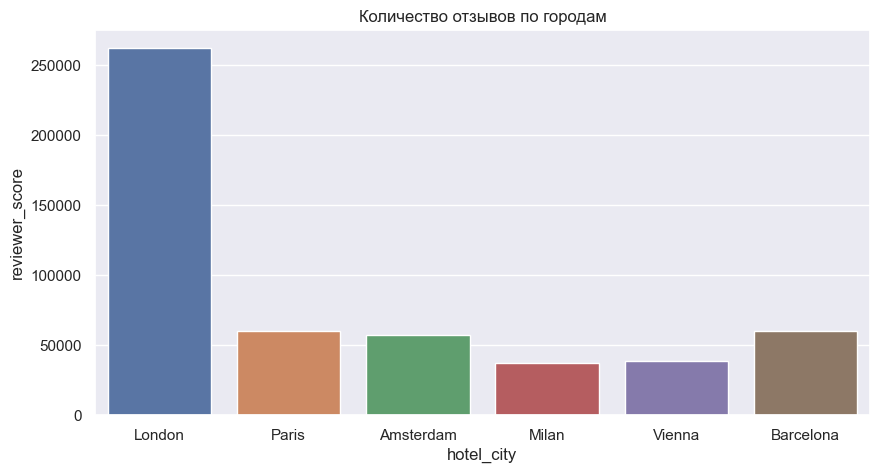

In [27]:
# Создаем специальную таблицу для визуализации
visdata = numdata.groupby('hotel_city', as_index=False)['reviewer_score'].count()

visdata['hotel_city'] = objdata['hotel_city'].unique().tolist()

# Создаем сам график
plt.figure(figsize=(10, 5))

title = 'Количество отзывов по городам'
sns.barplot(data=visdata, x='hotel_city', y='reviewer_score').set_title(title)

*Несравнимо больше всего отзывов оставляют в Лондоне, чем в других городах. На мой взгляд это связано именно с тем, что данные специально собирали таким образом, потому что я не думаю, что туризм во Франции или в Италии развит хуже, чем в Англии. Либо же там заведена такая культура, что нужно всегда оставлять отзывы.*

In [28]:
# Это категориальный признак, добавляем его в свой список
catcols += ['hotel_city']
catcols

['average_score', 'hotel_city']

In [29]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 11 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признак `'review_date'`

Дата отзыва важна, так как вероятно, что большинство людей путешествуют на выходных или в праздники, так что оценки, оставленные именно в эти дни будут более значимы для модели.

In [30]:
objdata['review_date'] 

0          2/19/2016
1          1/12/2017
2         10/18/2016
3          9/22/2015
4           3/5/2016
             ...    
515733      2/3/2016
515734     6/18/2016
515735      7/6/2017
515736    12/26/2015
515737    12/23/2015
Name: review_date, Length: 515738, dtype: object

In [31]:
# Нужно привести этот признак к формату дата-время 
# и выделить из него месяц и день недели

rewdate = pd.to_datetime(objdata['review_date'])

numdata['review_month'] = rewdate.dt.month
numdata['review_dayofweek'] = rewdate.dt.dayofweek

numdata[['review_month', 'review_dayofweek']] 

,review_month,review_dayofweek
0,2,4
1,1,3
2,10,1
3,9,1
4,3,5
...,...,...
515733,2,2
515734,6,5
515735,7,3
515736,12,5


Text(0.5, 1.0, 'Количество отзывов по месяцам')

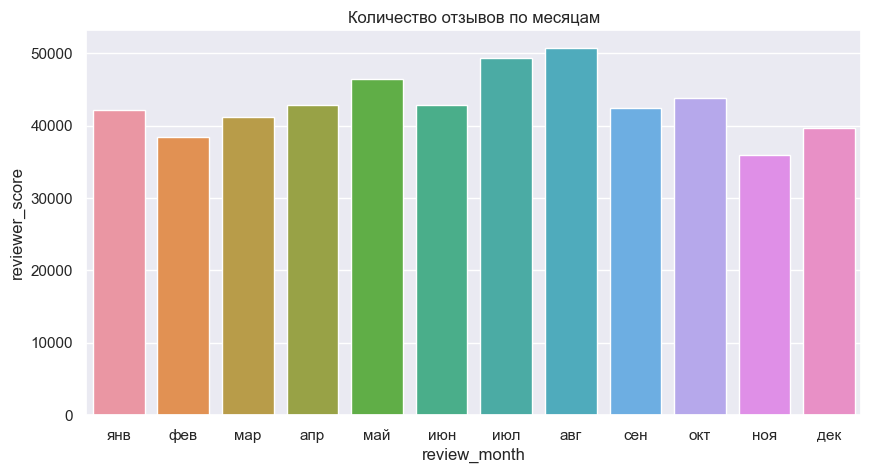

In [32]:
# Смотрим, какие месяцы отличаются большим количеством оценок
visdata = numdata.groupby('review_month', 
                          as_index=False)['reviewer_score'].count()

# Для удобства добавляем названия месяцев
visdata['review_month'] = ['янв', 'фев', 'мар', 'апр', 
                           'май', 'июн', 'июл', 'авг', 
                           'сен', 'окт', 'ноя', 'дек']

# График
plt.figure(figsize=(10, 5))

title = 'Количество отзывов по месяцам'
sns.barplot(data=visdata, x='review_month', y='reviewer_score').set_title(title)

*Невооруженным взглядом видится подъем в районе лета. Это логично, так как все города, где расположены отели, находятся в Европе, летом там как правило хорошая погода и это привлекает туристов.*

In [33]:
# Выделяем 1/3 самых "жарких" месяцев и кодируем их однократным способом
hot_season = numdata['review_month'].value_counts().iloc[:4]

gethot = lambda x: 1 if x in (hot_season.index) else 0
numdata['is_hot_season'] = numdata['review_month'].apply(gethot)

numdata['is_hot_season'] 

0         0
1         0
2         1
3         0
4         0
         ..
515733    0
515734    0
515735    1
515736    0
515737    0
Name: is_hot_season, Length: 515738, dtype: int64

In [34]:
catcols += ['review_month', 'is_hot_season']
catcols

['average_score', 'hotel_city', 'review_month', 'is_hot_season']

Text(0.5, 1.0, 'Количество отзывов по дням недели')

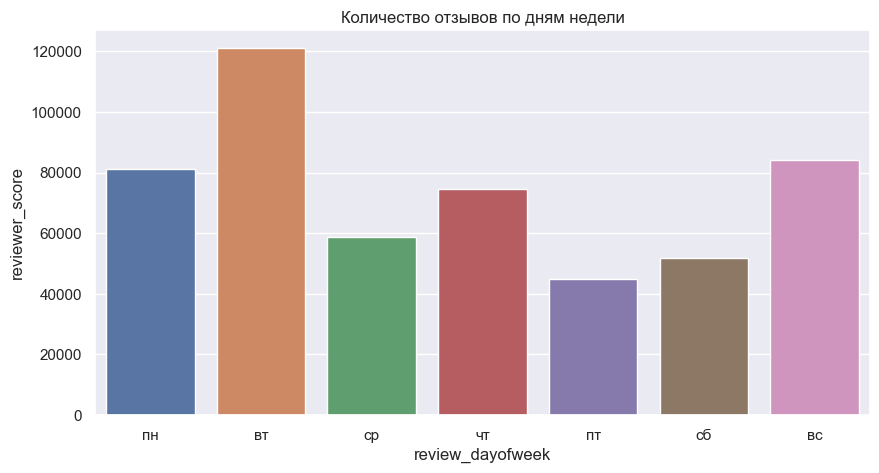

In [35]:
visdata = numdata.groupby('review_dayofweek', 
                          as_index=False)['reviewer_score'].count()

visdata['review_dayofweek'] = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']

plt.figure(figsize=(10, 5))

title = 'Количество отзывов по дням недели'
sns.barplot(data=visdata, x='review_dayofweek', y='reviewer_score').set_title(title)

*Как ни странно, но в выходные дни не наблюдается большего количества оценок, чем в другие, а больше всего отцывов оставляют почему-то во вторник. Если честно, у меня нет никаких гипотез касательно данной ситуации.*

In [36]:
# Выделим признак-флаг, является ли данный день выходным (на всякий случай)
numdata['is_weekend'] = numdata['review_dayofweek'].apply(lambda x: 1 if x in (5, 6) else 0)

numdata['is_weekend']

0         0
1         0
2         0
3         0
4         1
         ..
515733    0
515734    1
515735    0
515736    1
515737    0
Name: is_weekend, Length: 515738, dtype: int64

In [37]:
catcols += ['review_dayofweek', 'is_weekend']
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend']

In [38]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признак `'hotel_name'`

На мой взгляд, бренд отеля может сильно влиять на его оценку в том смысле, что определенная сеть отелей отличается высоким либо низким качеством обслуживания и ей как правило ставят соответствующие оценки.

In [39]:
objdata['hotel_name']

0                                The May Fair Hotel
1                   Mercure London Bloomsbury Hotel
2                 Legend Saint Germain by Elegancia
3         Mercure Paris 19 Philharmonie La Villette
4                       Golden Tulip Amsterdam West
                            ...                    
515733          Best Western Antares Hotel Concorde
515734                                   Medinaceli
515735                   Suite Hotel 900 m zur Oper
515736              Ch teau Monfort Relais Ch teaux
515737           Saint James Albany Paris Hotel Spa
Name: hotel_name, Length: 515738, dtype: object

In [40]:
# Выделяем только те отели, которые встречаются в таблице более тысячи раз,
# остальные помечаем как "другие"
h_names = objdata.groupby('hotel_name', as_index=False)['hotel_address'].count()
h_names = h_names.rename(columns={'hotel_address': 'cnt'})

h_tops = h_names[h_names['cnt'] >= 1000].reset_index(drop=True)

names = lambda x: x if x in h_tops['hotel_name'].to_list() else 'Other'
objdata['the_hotel'] = objdata['hotel_name'].apply(names)

objdata['the_hotel']

0                               Other
1                               Other
2                               Other
3                               Other
4         Golden Tulip Amsterdam West
                     ...             
515733                          Other
515734                          Other
515735                          Other
515736                          Other
515737                          Other
Name: the_hotel, Length: 515738, dtype: object

In [41]:
# Кодируем эти названия бинарным способом
h_enc = encoder(objdata, 'the_hotel', 'binary')
numdata = pd.concat([numdata, h_enc], axis=1)

In [42]:
cs = []
for col in numdata.columns:
    if 'the_hotel_' in col:
        cs.append(col)

numdata[cs]

,the_hotel_0,the_hotel_1,the_hotel_2,the_hotel_3,the_hotel_4,the_hotel_5,the_hotel_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
515733,0,0,0,0,0,0,1
515734,0,0,0,0,0,0,1
515735,0,0,0,0,0,0,1
515736,0,0,0,0,0,0,1


*Визуализации не будет, так как названия отелей зашифрованы в бинарный код и визуализировать его будет невозможно.*

In [43]:
catcols += h_enc.columns.tolist()
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6']

In [44]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признак `'reviewer_nationality'`

Национальность туриста, на самом деле, влияет на оценку, так как в соответствии со своими культурными особенностями и национальным этикетом, люди реагируют на обслуживание в разных странах по разному. К тому же на результат обучения модели больше всего влияют те, кто оставляют оценки чаще всего.

In [45]:
objdata['reviewer_nationality']

0                    United Kingdom 
1                    United Kingdom 
2                             China 
3                    United Kingdom 
4                            Poland 
                     ...            
515733                       Greece 
515734     United States of America 
515735                  New Zealand 
515736                    Australia 
515737               United Kingdom 
Name: reviewer_nationality, Length: 515738, dtype: object

In [46]:
country = pd.Series(countries)
country = country.apply(lambda x: 'United Kingdom' if x == 'UK' else x)

nation = objdata['reviewer_nationality'].apply(lambda y: y.strip())

is_resident = nation == country
numdata['is_resident_reviewer'] = is_resident.astype('int') 

In [47]:
# Информация с сайта 
# https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent

europe = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 
          'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
          'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 
          'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 
          'Kazakhstan', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 
          'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 
          'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 
          'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 
          'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican City'] 

numdata['is_european_reviewer'] = nation.apply(lambda x: 1 if x in europe else 0)


asia = ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 
        'Bhutan', 'Brunei', 'Cambodia', 'China', 'Georgia', 
        'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq',
        'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait',
        'Kyrgyzstan', 'Laos', 'Lebanon', 'Macau', 'Malaysia',
        'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea',
        'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar',
        'Russia', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka',
        'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'East Timor',
        'Turkey', 'Turkmenistan', 'United Arab Emirates', 
        'Uzbekistan', 'Vietnam', 'Yemen']

numdata['is_asian_reviewer'] = nation.apply(lambda x: 1 if x in asia else 0)


america = ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada',
           'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 
           'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 
           'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts and Nevis', 'Saint Lucia', 
           'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 
           'United States of America', 'Argentina', 'Bolivia', 'Brazil', 'Chile', 
           'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 
           'Suriname', 'Uruguay', 'Venezuela']

numdata['is_american_reviewer'] = nation.apply(lambda x: 1 if x in america else 0)


def get_other(nation):
    if ((nation not in europe) 
        and (nation not in asia) 
        and (nation not in america)):
        return 1
    return 0

numdata['is_other_reviewer'] = nation.apply(get_other)

numdata[['is_resident_reviewer', 
         'is_european_reviewer', 
         'is_asian_reviewer', 
         'is_american_reviewer', 
         'is_other_reviewer']]

,is_resident_reviewer,is_european_reviewer,is_asian_reviewer,is_american_reviewer,is_other_reviewer
0,1,1,0,0,0
1,1,1,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
515733,0,1,0,0,0
515734,0,0,0,1,0
515735,0,0,0,0,1
515736,0,0,0,0,1


Text(0.5, 1.0, 'Количество отзывов по национальностям рецензентов')

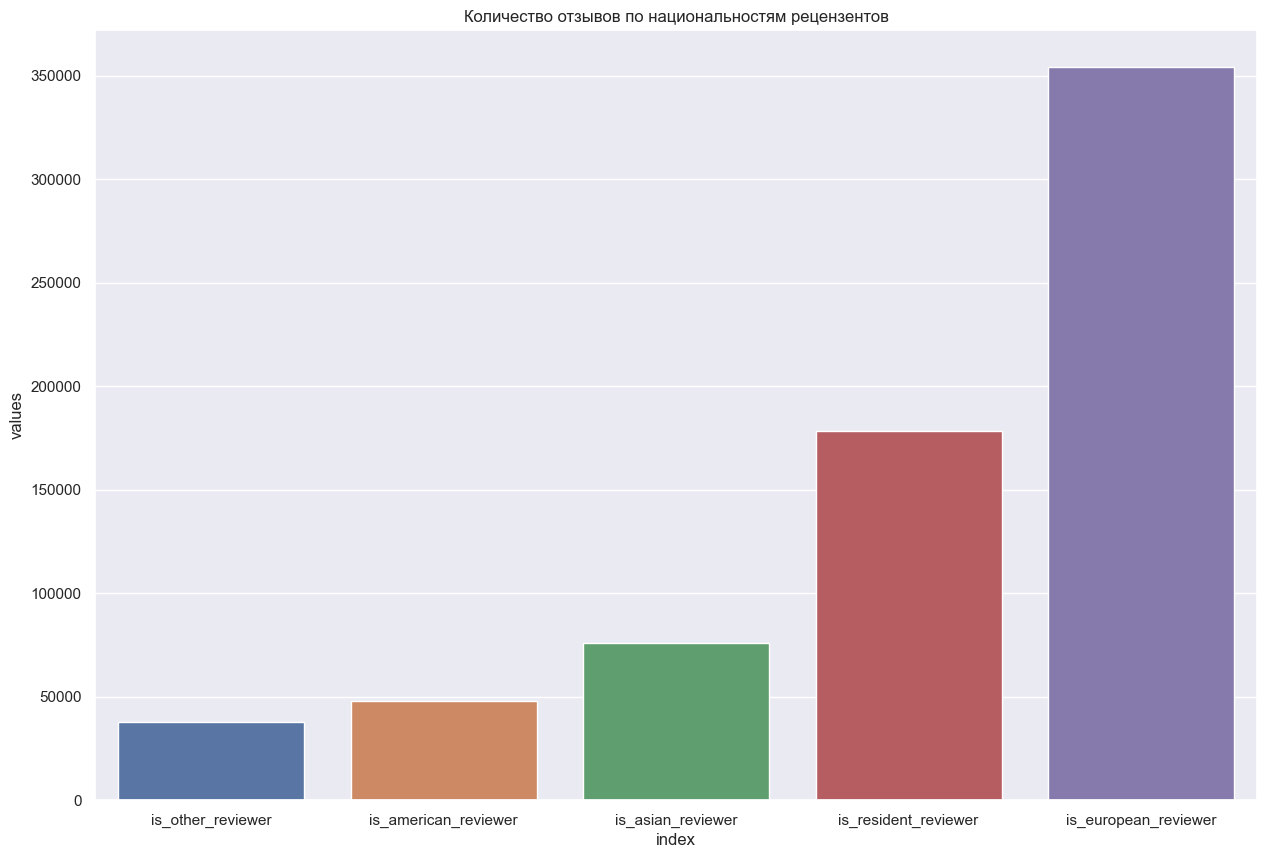

In [48]:
sumcols = []
for col in numdata.columns:
    if ('is_' in col) and ('_reviewer' in col):
        sumcols += [col]

sumdata = numdata[sumcols].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

plt.figure(figsize=(15, 10))

title = 'Количество отзывов по национальностям рецензентов'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Ожидаемо, что по миру больше всего путешествуют европейцы, так как имеют больше денег для этого. Далее, по своей стране тоже ездить намного легче, так как нет языкового барьера. Ну и поскольку города с отелями находятся в Европе, туристы из Азии, Америки и других частей света приезжают относительно нечасто.*

In [49]:
for col in numdata.columns:
    if '_reviewer' in col:
        catcols += [col]

catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer']

In [50]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признаки `'positive_review'` и `'negative_review'`

Непосредственно отзыв - это пожалуй самый важный признак, так как он содержит информацию, наиболее прямым образом связанную с той или иной оценкой. Здесь он разделен на положительные и отрицательные отзывы.

In [51]:
objdata[['positive_review', 'negative_review']] 

,positive_review,negative_review
0,Staff were amazing,Leaving
1,location,poor breakfast
2,No Positive,No kettle in room
3,Friendly staff quiet comfortable room spotles...,No Negative
4,The staff was very friendly and helpful Break...,Torn sheets
...,...,...
515733,nice breakfast,No Negative
515734,Beautiful historic hotel in great location in...,No Negative
515735,The size of the room the courtyard and the lo...,No coffee in complimentary coffee in the room...
515736,Staff very polite and helpful Hotel well loca...,No Negative


In [52]:
# Закодируем признаки, если в них есть отзыв или нет
numdata['is_there_positive'] = objdata['positive_review'].apply(lambda w: 0 if w == 'No Positive' else 1) 
numdata['is_there_negative'] = objdata['negative_review'].apply(lambda w: 0 if w == 'No Negative' else 1) 

numdata[['is_there_positive', 'is_there_negative']]

,is_there_positive,is_there_negative
0,1,1
1,1,1
2,0,1
3,1,0
4,1,1
...,...,...
515733,1,0
515734,1,0
515735,1,1
515736,1,0


Text(0.5, 1.0, 'Количество существующих отзывов')

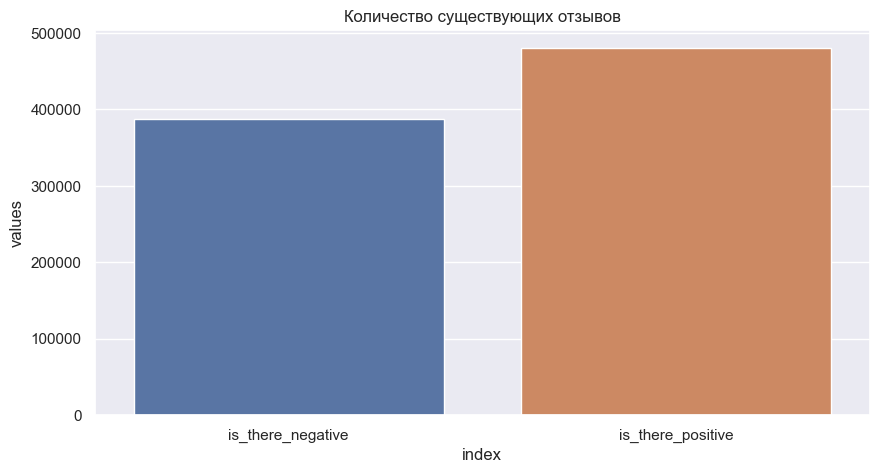

In [53]:
# Чтобы сождать таблицу для визуализации, нужно сначала суммировать новые признаки,
# а потом создать саму таблицу, где будет 2 столбца 
# с самими признаками и значениями их суммы
sumdata = numdata[['is_there_positive', 
                   'is_there_negative']].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(10, 5))

title = 'Количество существующих отзывов'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Все-таки отели стараются работать лучше, поэтому позитивных отзывов больше, чем негативных.*

In [54]:
catcols += ['is_there_positive', 'is_there_negative']

catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative']

---

In [55]:
# Сначала обработаем положительные рецензии.
# Там, где нет отзыва, просто делаем одно слово

posdata = objdata['positive_review'].apply(lambda x: x.strip().lower())
posdata = posdata.apply(lambda x: 'nopositive' if x == 'no positive' else x)

posdata

0                                        staff were amazing
1                                                  location
2                                                nopositive
3         friendly staff quiet comfortable room spotless...
4         the staff was very friendly and helpful breakf...
                                ...                        
515733                                       nice breakfast
515734    beautiful historic hotel in great location in ...
515735    the size of the room the courtyard and the loc...
515736    staff very polite and helpful hotel well locat...
515737                                           nopositive
Name: positive_review, Length: 515738, dtype: object

In [56]:
# Создаем множество уникальных слов, которые встречаются в рецензиях более 100 раз
# Из этого множества мы вручную вычленяем ключевые слова
pos_vc = posdata.value_counts()
top_pos = pos_vc[pos_vc >= 100].index.tolist()

pos_set = set()

for x in top_pos:
    x = x.split(' ')
    for y in x:
        pos_set.add(y)
        
pos_set

{'',
 'all',
 'and',
 'bed',
 'breakfast',
 'central',
 'clean',
 'cleanliness',
 'comfortable',
 'comfy',
 'convenient',
 'every',
 'everything',
 'excellent',
 'fantastic',
 'friendly',
 'good',
 'great',
 'helpful',
 'hotel',
 'is',
 'location',
 'much',
 'nice',
 'nopositive',
 'not',
 'nothing',
 'of',
 'only',
 'perfect',
 'position',
 'room',
 'service',
 'staff',
 'the',
 'thing',
 'very',
 'view',
 'was',
 'were'}

In [57]:
# Берем только существительные, так как прилагательные применяются именно к ним 
# и понятно, что они имеют положительную окраску
goods = ['all', 'bed', 'breakfast', 'clean', 'everything', 
         'hotel', 'location', 'position', 'room', 'service', 
         'staff', 'view', 'nothing']

# Кодируем однократным образом 
for g in goods:
    numdata['good_' + g] = posdata.apply(lambda x: 1 if g in x else 0)

In [58]:
cs = []
for col in numdata.columns:
    if 'good_' in col:
        catcols += [col]
        cs.append(col)

numdata[cs]

,good_all,good_bed,good_breakfast,good_clean,good_everything,good_hotel,good_location,good_position,good_room,good_service,good_staff,good_view,good_nothing
0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,1,0,1,0,0
4,0,0,1,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,0,1,0,0,0,0,0,0,0,0,0,0
515734,0,0,0,0,0,1,1,0,0,0,0,0,0
515735,1,0,0,0,0,0,1,0,1,0,1,0,0
515736,0,0,0,1,0,1,0,0,1,0,1,0,0


Text(0.5, 1.0, 'Какие положительные качества чаще всего указывают в отзыве')

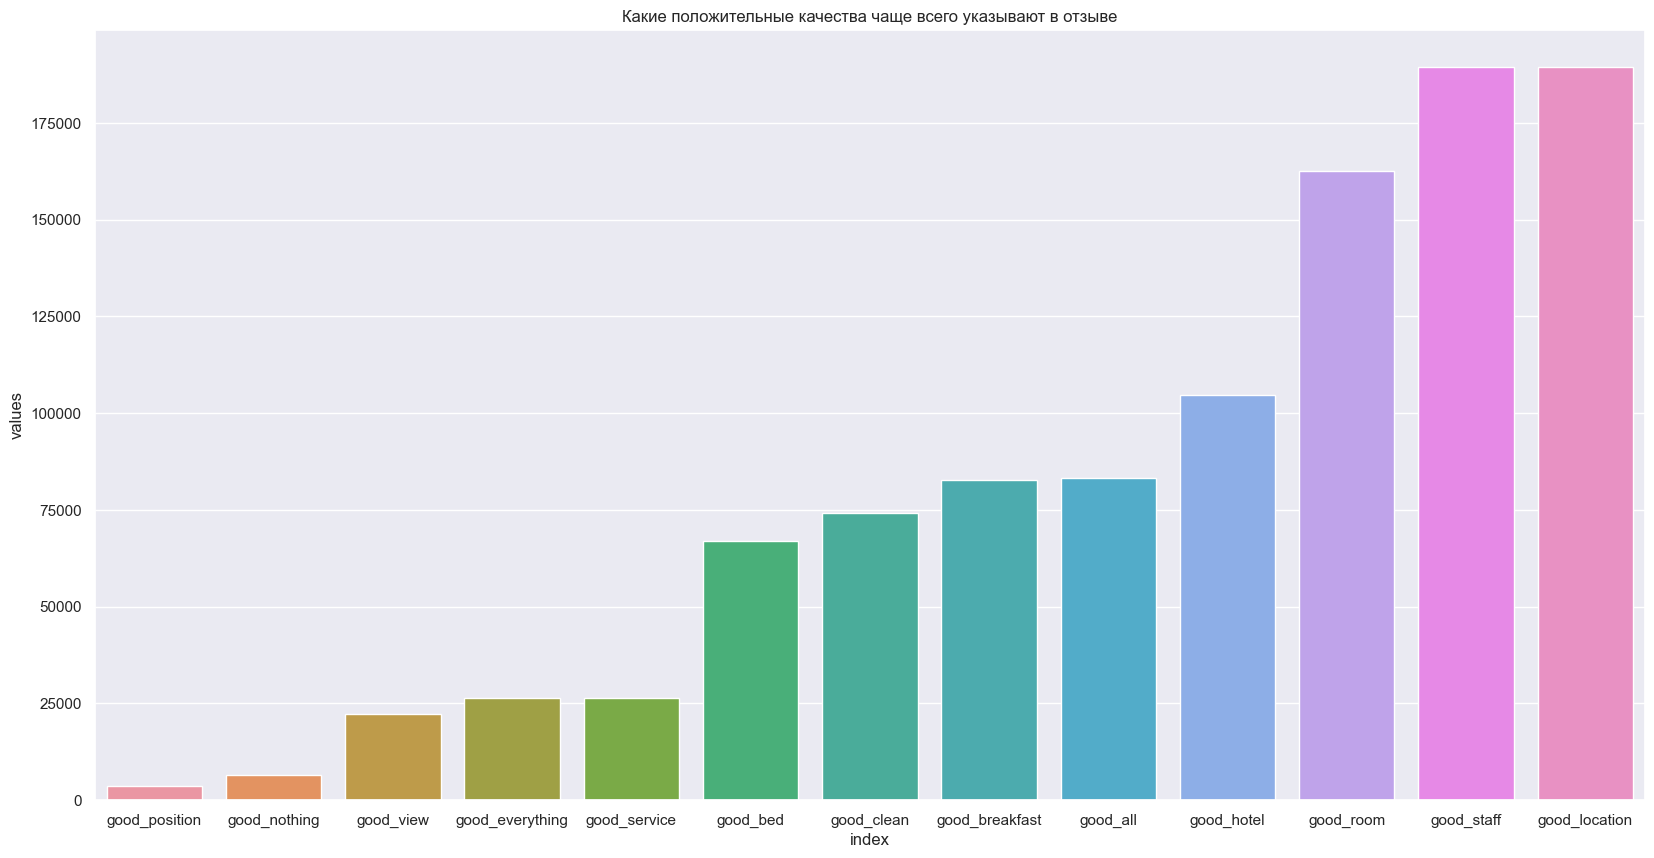

In [59]:
# Суммируем все хорошее
sumcols = []
for col in numdata.columns:
    if 'good_' in col:
        sumcols += [col]

sumdata = numdata[sumcols].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(20, 10))

title = 'Какие положительные качества чаще всего указывают в отзыве'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Позитивные моменты можно условно разделить на 3 группы.*
1. *Чаще всего в качестве плюсов отеля указывают локацию, персонал и номер, то есть это фактически первое, на что турист обращает внимание.*
2. *Менее важными рецензенты считают завтрак, чистоту и кровати. Некоторые люди, вероятно, просто не завтракают в отеле и неприхотливы к общим условиям.*
3. *Совсем мало оценок получает вид из окна (сервис и позиция как синонимы персонала и локации). Это странно, ведь локация играет самую важную роль, либо же сами постояльцы редко смотрят в окна.*

In [60]:
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing']

In [61]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

In [62]:
# Теперь рассмотрим отрицательные рецензии тем же самым методом
negdata = objdata['negative_review'].apply(lambda x: x.strip().lower())
negdata = negdata.apply(lambda x: 'nonegative' if x == 'no negative' else x)

negdata

0                                                   leaving
1                                            poor breakfast
2                                         no kettle in room
3                                                nonegative
4                                               torn sheets
                                ...                        
515733                                           nonegative
515734                                           nonegative
515735    no coffee in complimentary coffee in the room ...
515736                                           nonegative
515737                rooms were very dated and old fashion
Name: negative_review, Length: 515738, dtype: object

In [63]:
neg_vc = negdata.value_counts()
top_neg = neg_vc[neg_vc >= 100].index.tolist()

neg_set = set()

for x in top_neg:
    x = x.split(' ')
    for y in x:
        neg_set.add(y)
        
neg_set

{'',
 'a',
 'about',
 'above',
 'absolutely',
 'all',
 'anything',
 'applicable',
 'at',
 'breakfast',
 'can',
 'comes',
 'complain',
 'complaints',
 'dislike',
 'everything',
 'expensive',
 'fine',
 'good',
 'great',
 'having',
 'i',
 'in',
 'included',
 'it',
 'leave',
 'leaving',
 'like',
 'liked',
 'location',
 'mind',
 'much',
 'n',
 'na',
 'nil',
 'no',
 'non',
 'none',
 'nonegative',
 'not',
 'nothing',
 'of',
 'parking',
 'particular',
 'perfect',
 'pillows',
 'price',
 'really',
 'room',
 'rooms',
 'see',
 'size',
 'small',
 'staff',
 't',
 'the',
 'think',
 'to',
 'too',
 'very',
 'was',
 'wifi'}

In [64]:
bads = ['all', 'breakfast', 'everything', 'expensive', 
        'location', 'nothing', 'parking', 'pillows', 
        'price', 'room', 'size', 'staff', 'wifi']

for b in bads:
    numdata['bad_' + b] = negdata.apply(lambda x: 1 if b in x else 0)

In [65]:
cs = []
for col in numdata.columns:
    if 'bad_' in col:
        catcols += [col]
        cs.append(col)

numdata[cs]

,bad_all,bad_breakfast,bad_everything,bad_expensive,bad_location,bad_nothing,bad_parking,bad_pillows,bad_price,bad_room,bad_size,bad_staff,bad_wifi
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,0,0,0,0,0,0,0,0,0,0,0,0
515734,0,0,0,0,0,0,0,0,0,0,0,0,0
515735,0,1,0,0,0,0,0,0,0,1,0,0,0
515736,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Какие отрицательные качества чаще всего указывают в отзыве')

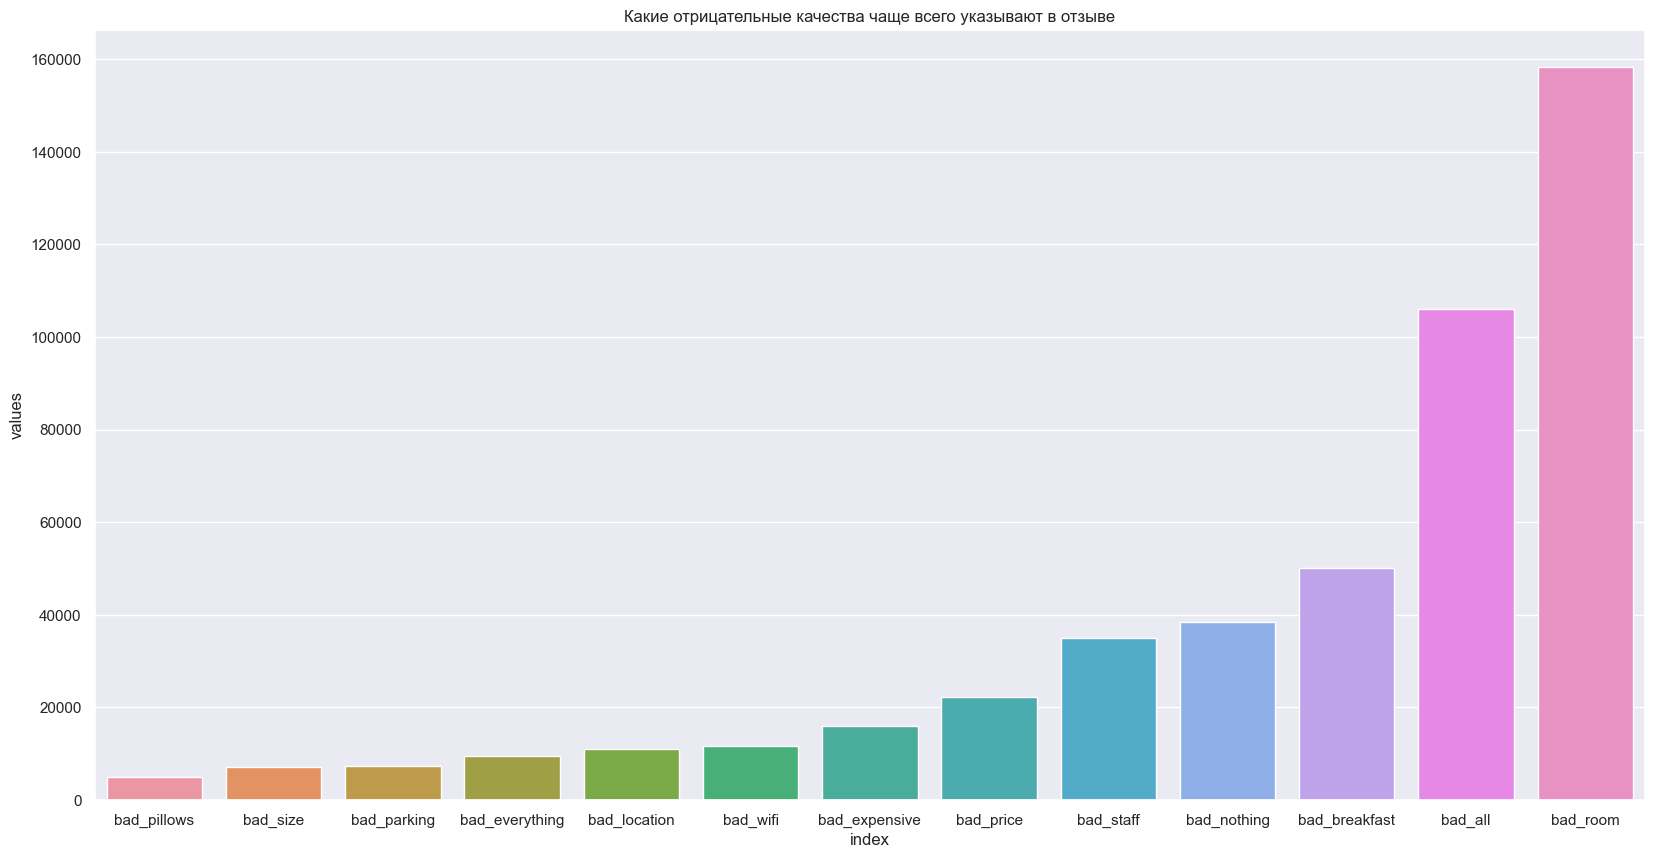

In [66]:
sumcols = []
for col in numdata.columns:
    if 'bad_' in col:
        sumcols += [col]

sumdata = numdata[sumcols].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

plt.figure(figsize=(20, 10))

title = 'Какие отрицательные качества чаще всего указывают в отзыве'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Постояльцам очень не нравятся номера, так как это наиболее непосредственным образом указывает на качество отеля. Также люди бывают настолько разочарованы, что им не нравится всё, в буквальном смысле всё. Ну а потом, они отмечают, что в отеле был плохой завтрак, персонал, было неоправданно дорого, медленный wi-fi, неудобная локация, паркинг, размер комнаты или кровати, и подушки.* 

*Я заметил, что в положительных отзывах люди чаще обращают внимание на детали, в то время как в отрицательных указывают наиболее общие критерии.*

In [67]:
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing',
 'bad_all',
 'bad_breakfast',
 'bad_everything',
 'bad_expensive',
 'bad_location',
 'bad_nothing',
 'bad_parking',
 'bad_pillows',
 'bad_price',
 'bad_room',
 'bad_size',
 'bad_staff',
 'bad_wifi']

In [68]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признак `'tags'`

Здесь могут находиться категории как самого отеля, так и рецензента, котрые ввиду соответствия или несоответствия друг другу, могут влиять на оценку.

In [69]:
objdata['tags']

0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
515733    [' Business trip ', ' Couple ', ' Double Room ...
515734    [' Leisure trip ', ' Couple ', ' Double Room '...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Execut...
515737    [' Leisure trip ', ' Couple ', ' Standard Room...
Name: tags, Length: 515738, dtype: object

In [70]:
# Избавимся от квадратных скобок как символа, разделим по запятым
tags = objdata['tags'].apply(lambda x: x.strip('[]').split(','))

# Избавимся также от ненужных кавычек и пробелов
tags = tags.apply(lambda x: [y.strip("' '") for y in x])

tags

0         [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Solo traveler, Modern Double Ro...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
515733    [Business trip, Couple, Double Room, Stayed 4 ...
515734    [Leisure trip, Couple, Double Room, Stayed 2 n...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Executive Double...
515737    [Leisure trip, Couple, Standard Room with Spa ...
Name: tags, Length: 515738, dtype: object

In [71]:
# Посмотрим, какие теги вообще существуют
# Для этого узнаем, сколько их может быть максимально
lens = tags.apply(lambda x: len(x)).rename('len')

dt = pd.concat([tags, lens], axis=1).sort_values(by='len', ascending=False)

dt['tags'].iloc[0]

['With a pet',
 'Business trip',
 'Couple',
 'Classic Double Room',
 'Stayed 3 nights',
 'Submitted from a mobile device']

In [72]:
# Мы видим, что существует 6 типов тегов: 
# Поездка с домашними животными, тип поездки, тип постояльца, 
# тип номера, количество ночей и был ли отзыв отправлен с телефона

numdata['trip_type'] = tags.apply(lambda tag: 1 if 'Leisure trip' in tag else 0)
numdata['with_pets'] = tags.apply(lambda tag: 1 if 'With a pet' in tag else 0)
numdata['from_mobile'] = tags.apply(lambda tag: 1 if 'Submitted from a mobile device' in tag else 0)

# Кодируем их
numdata[['trip_type', 'with_pets', 'from_mobile']]

,trip_type,with_pets,from_mobile
0,1,0,1
1,0,0,0
2,1,0,1
3,1,0,0
4,0,0,0
...,...,...,...
515733,0,0,0
515734,1,0,1
515735,0,0,0
515736,1,0,1


Text(0.5, 1.0, 'Какие положительные качества чаще всего указывают в отзыве')

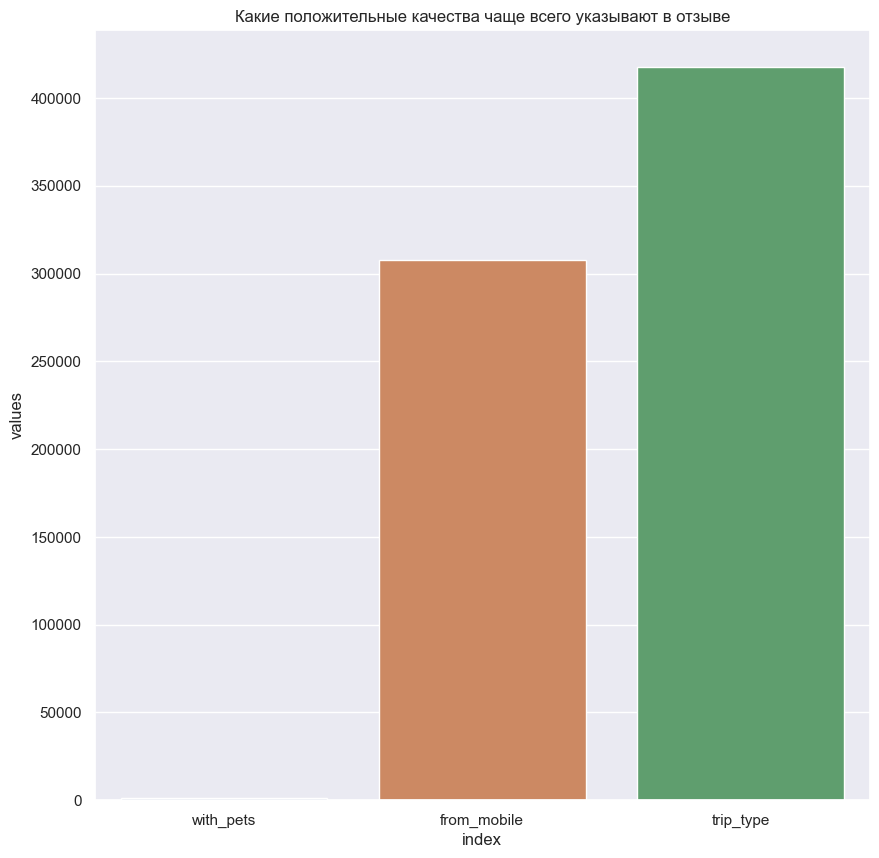

In [73]:
# Визуализация
sumdata = numdata[['trip_type', 'with_pets', 'from_mobile']].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(10, 10))

title = 'Какие положительные качества чаще всего указывают в отзыве'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Оказалось, что с домашними животными люди практически не путешествуют, это скорее исключение из правила. Это правда, что не каждая гостиница готова принимать туристов с питомцами, да и везти их с собой - это огромный стресс, поэтому лучше их оставить дома.*

In [74]:
catcols += ['trip_type', 'with_pets', 'from_mobile'] 
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing',
 'bad_all',
 'bad_breakfast',
 'bad_everything',
 'bad_expensive',
 'bad_location',
 'bad_nothing',
 'bad_parking',
 'bad_pillows',
 'bad_price',
 'bad_room',
 'bad_size',
 'bad_staff',
 'bad_wifi',
 'trip_type',
 'with_pets',
 'from_mobile']

In [75]:
# Выделяем тип рецензента из тегов, он как правило указывается вторым по счету
travtype = tags.apply(lambda x: x[1] if len(x) > 3 else '0')

# Однако также вторым указывается и тип номера, убираем их
travtype = travtype.apply(lambda y: y if 'Room' not in y else '0')
types = travtype.unique().tolist()[:7]

# убираю ноль таким образом, так как types.remove('0') возвращает None
types = types[:4] + types[5:] 

# Заносим типы рецензентов в словарь, где значениями будут их порядковые числа
trav_types = dict()

for i, t in enumerate(types):
    trav_types[t] = i+1

# Таким образом получается порядковое кодирование
numdata['trav_type'] = tags.apply(lambda tag: [v for k, v in trav_types.items() if k in tag])
numdata['trav_type'] = numdata['trav_type'].apply(lambda x: x[0]) 

numdata['trav_type'] 

0         1
1         1
2         2
3         2
4         1
         ..
515733    1
515734    1
515735    2
515736    2
515737    1
Name: trav_type, Length: 515738, dtype: int64

Text(0.5, 1.0, 'Какие типы путешественников чаще всего пишут отзывы')

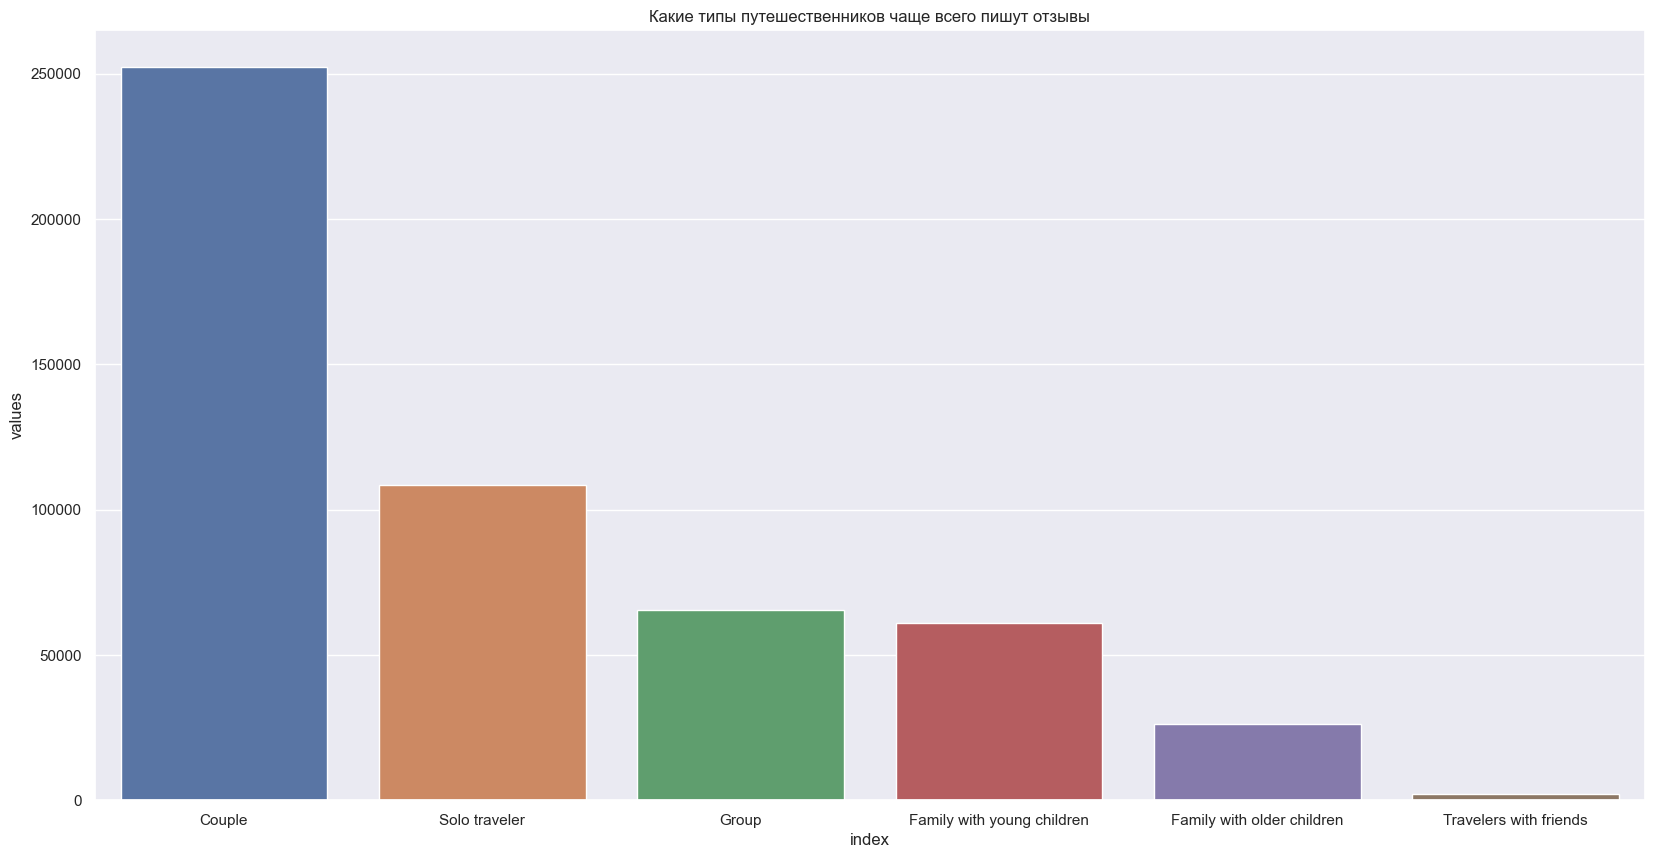

In [76]:
# Для удобства визуализации берем строковые названия типов
objdata['trav_type'] = tags.apply(lambda tag: [k for k in trav_types.keys() if k in tag])
objdata['trav_type'] = objdata['trav_type'].apply(lambda x: x[0])

# Счетчики типов
sumdata = objdata['trav_type'].value_counts()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(20, 10))

title = 'Какие типы путешественников чаще всего пишут отзывы'
sns.barplot(data=visdata, x='index', y='values').set_title(title)

*Конечно же чаще всего люди путешествуют парами, ибо так романтичнее, или одному, ибо так дешевле. А путешествовать в группе, с детьми или друзьями оказывается не только дорого, но и хлопотно.*

In [77]:
catcols += ['trav_type']
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing',
 'bad_all',
 'bad_breakfast',
 'bad_everything',
 'bad_expensive',
 'bad_location',
 'bad_nothing',
 'bad_parking',
 'bad_pillows',
 'bad_price',
 'bad_room',
 'bad_size',
 'bad_staff',
 'bad_wifi',
 'trip_type',
 'with_pets',
 'from_mobile',
 'trav_type']

---

In [78]:
# Узнаем, на сколько ночей останавливаются туристы
def get_nights(tag):
    for t in tag:
        if 'Stayed' in t:
            t = t.split(' ')[1]
            return int(t)

nights = tags.apply(get_nights)

# Если количество ночей не указано, на это место ставим пропуск
stayed_nights = nights.apply(lambda x: np.nan if x == None else x)

stayed_nights

0         2.0
1         1.0
2         3.0
3         1.0
4         6.0
         ... 
515733    4.0
515734    2.0
515735    2.0
515736    3.0
515737    2.0
Name: tags, Length: 515738, dtype: float64

Text(0.5, 1.0, 'На сколько ночей оставливаются рецензенты, распределение')

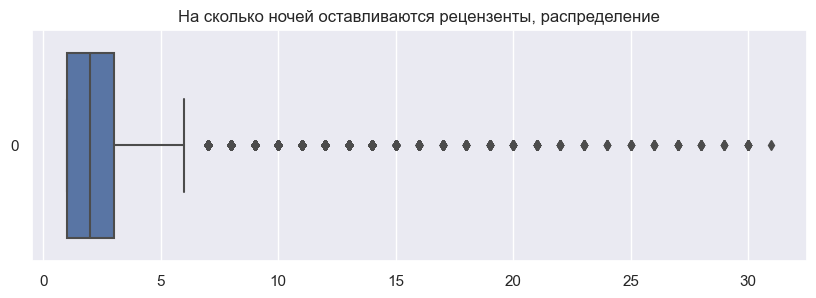

In [79]:
# Нужно заполнить пропуски средним или медианным значением, 
# посмотрим как распределены данные
plt.figure(figsize=(10, 3)) 

title = 'На сколько ночей оставливаются рецензенты, распределение'
sns.boxplot(data=stayed_nights, orient='h').set_title(title)

In [80]:
# Так как в данных много выбросов, заполняем пропуски медианным значением
stayed_nights = stayed_nights.fillna(stayed_nights.median())
numdata['stayed_nights'] = stayed_nights.astype('int') 

numdata['stayed_nights']

0         2
1         1
2         3
3         1
4         6
         ..
515733    4
515734    2
515735    2
515736    3
515737    2
Name: stayed_nights, Length: 515738, dtype: int32

<AxesSubplot: xlabel='index', ylabel='values'>

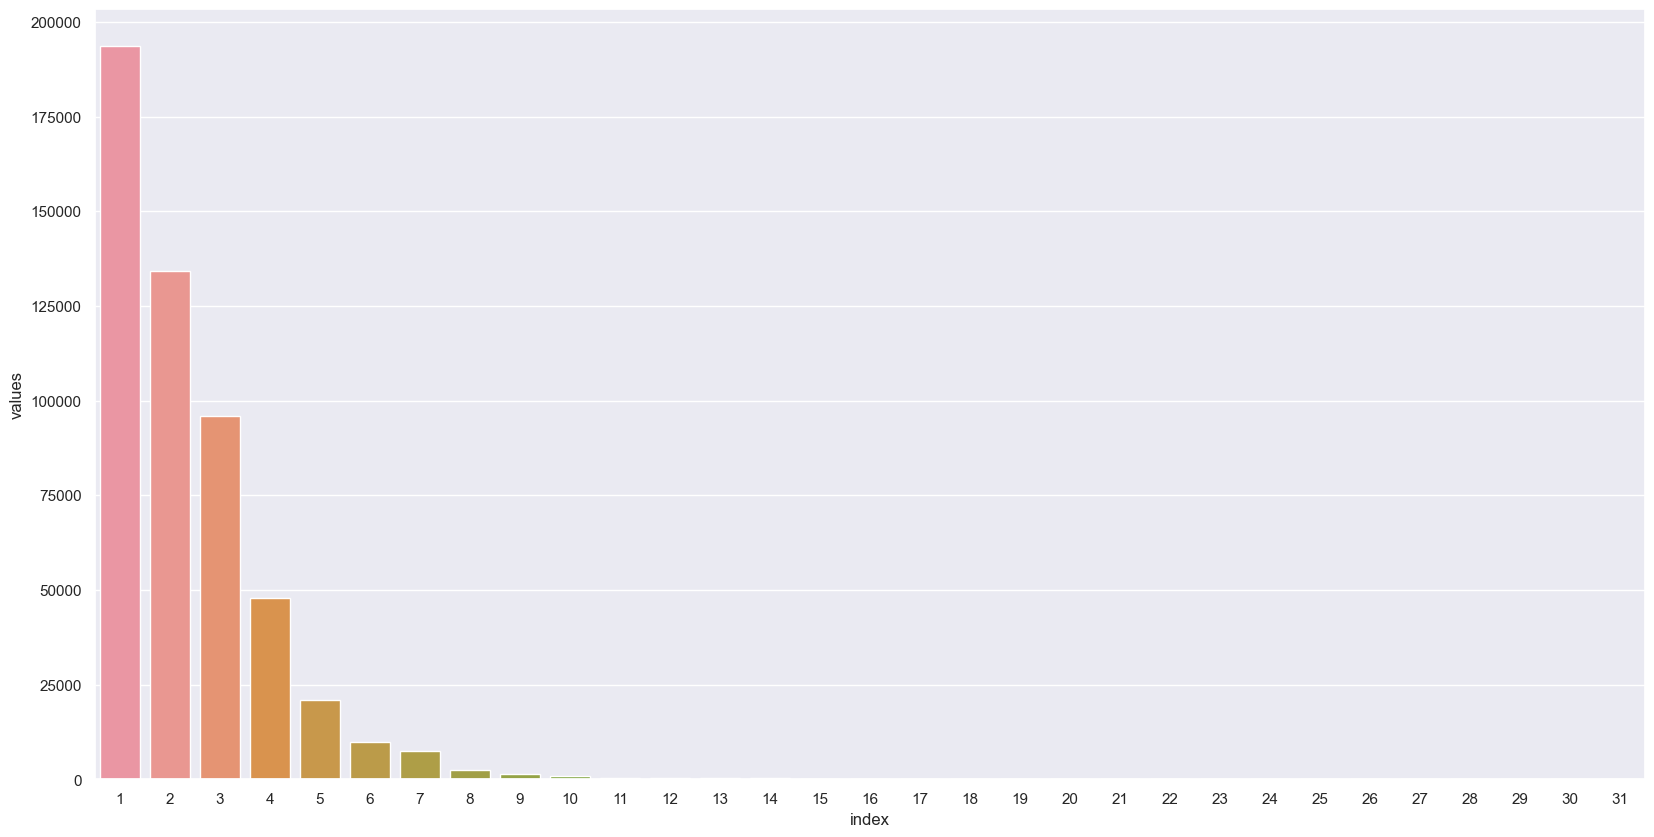

In [81]:
# Визуализация
sumdata = numdata['stayed_nights'].value_counts()

visdata = pd.DataFrame() 
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(20, 10))

sns.barplot(data=visdata, x='index', y='values')

*Чаще всего в отелях останавливаются на минимальное количество ночей. Вероятно в целях экономии, так как основные достопримечательности можно обойти за пару дней. А остальные дни требуются для деловых поездок, которые могут длиться и месяц.*

In [82]:
# Это непрерывный признак
numcols += ['stayed_nights']
numcols 

['additional_number_of_scoring',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'stayed_nights']

---

In [83]:
# Теперь самое интересное, типы номеров
# Занесем все теги во множество, чтобы были только уникальные значения
utags = set()

for tag in tags:
    for t in tag:
        utags.add(t)

len(utags)

2428

In [84]:
# Теперь удалим из этого множества все теги, которые мы обрабатывали ранее
rooms = list(utags.copy())

for utag in rooms:
    if ((utag == 'Leisure trip') or (utag == 'Business trip')
       or (utag == 'With a pet')
       or (utag == 'Submitted from a mobile device')
       or (utag in trav_types.keys()) 
       or ('Stayed' in utag)):
        rooms.remove(utag)
        
len(rooms)

2387

In [85]:
# Теперь создаем столбец только с типами номеров
def get_room(tag):
    for t in tag:
        if t in rooms:
            return t

room = tags.apply(get_room)

room

0                            Studio Suite
1                    Standard Double Room
2                 Modern Double Room Echo
3         Standard Room with 1 Double Bed
4            Standard Double or Twin Room
                       ...               
515733                        Double Room
515734                        Double Room
515735                        Single Room
515736      Executive Double or Twin Room
515737      Standard Room with Spa access
Name: tags, Length: 515738, dtype: object

In [86]:
# Для простоты выберем только те типы, которые встречаются больше 1000 раз
# Остальные помечаем как другие

roomdata = room.value_counts()
roomlist = roomdata[roomdata >= 1000].index.tolist() 
roomtype = room.apply(lambda r: r if r in roomlist else 'Other') 

roomtype

0                                 Other
1                  Standard Double Room
2                                 Other
3                                 Other
4          Standard Double or Twin Room
                      ...              
515733                      Double Room
515734                      Double Room
515735                      Single Room
515736    Executive Double or Twin Room
515737                            Other
Name: tags, Length: 515738, dtype: object

In [87]:
# Выбираем вручную, какие типы комнат отметить
roomtype.unique().tolist()

['Other',
 'Standard Double Room',
 'Standard Double or Twin Room',
 'Superior Twin Room',
 'Double Room Non Smoking',
 'Superior Double Room',
 'Double Room',
 'Double or Twin Room',
 'Standard Room',
 'Comfort Double or Twin Room',
 'Standard',
 'Executive Double Room',
 '2 rooms',
 'Luxury Double Room',
 'Standard Double Room without Window',
 'Basic Double Room',
 'Classic Double Room',
 'Deluxe King Room',
 'Double Guest Room',
 'Standard Twin Room',
 'Twin Room',
 'Small Queen Room',
 'Triple Room',
 'Superior Room',
 'Deluxe Twin Room',
 'Deluxe Double Room',
 'Executive King Room',
 'Classic Double or Twin Room',
 'Single Room',
 'Queen Guest Room',
 'Standard Queen Room',
 'King Guest Room',
 'Classic Room',
 'Queen Room',
 'Club Double Room',
 'Large Double Room',
 'Deluxe Single Room',
 'Standard Single Room',
 'Standard Triple Room',
 'Deluxe Double or Twin Room',
 'Classic Single Room',
 'Deluxe King or Twin Room',
 'Superior King Room',
 'Club Twin Room',
 'Cosy Double Ro

In [88]:
# Вот что у нас получилось, кодируем их однократным способом
roomtypes_list = ['Double', 'Standard', 'Superior', 'Deluxe', 'Twin', 
                  'Classic', '2 rooms', 'Single', 'Executive', 'Club', 
                  'Queen', 'King', 'Junior', 'Triple', 'Guest', 
                  'Small', 'Basic', 'Comfort', 'without Window', '1 2 Adults', 
                  'Family', 'Suite', 'Cosy', 'Hilton', 'Guestroom', 
                  'Non Smoking', 'Economy', 'Large', 'Quadruple', 'Luxury', 
                  'with Internal View', 'with Two Double Beds', 'Dorsett', 'Other']

for rt in roomtypes_list:
    numdata['is_' + rt.lower() + '_room'] = roomtype.apply(lambda r: 1 if rt in r else 0)

In [89]:
cs = []
for col in numdata.columns:
    if ('is_' in col) and ('_room' in col):
        cs.append(col)
        
numdata[cs]  

,is_double_room,is_standard_room,is_superior_room,is_deluxe_room,is_twin_room,is_classic_room,is_2 rooms_room,is_single_room,is_executive_room,is_club_room,...,is_guestroom_room,is_non smoking_room,is_economy_room,is_large_room,is_quadruple_room,is_luxury_room,is_with internal view_room,is_with two double beds_room,is_dorsett_room,is_other_room
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515734,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515735,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
515736,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Какие положительные качества чаще всего указывают в отзыве')

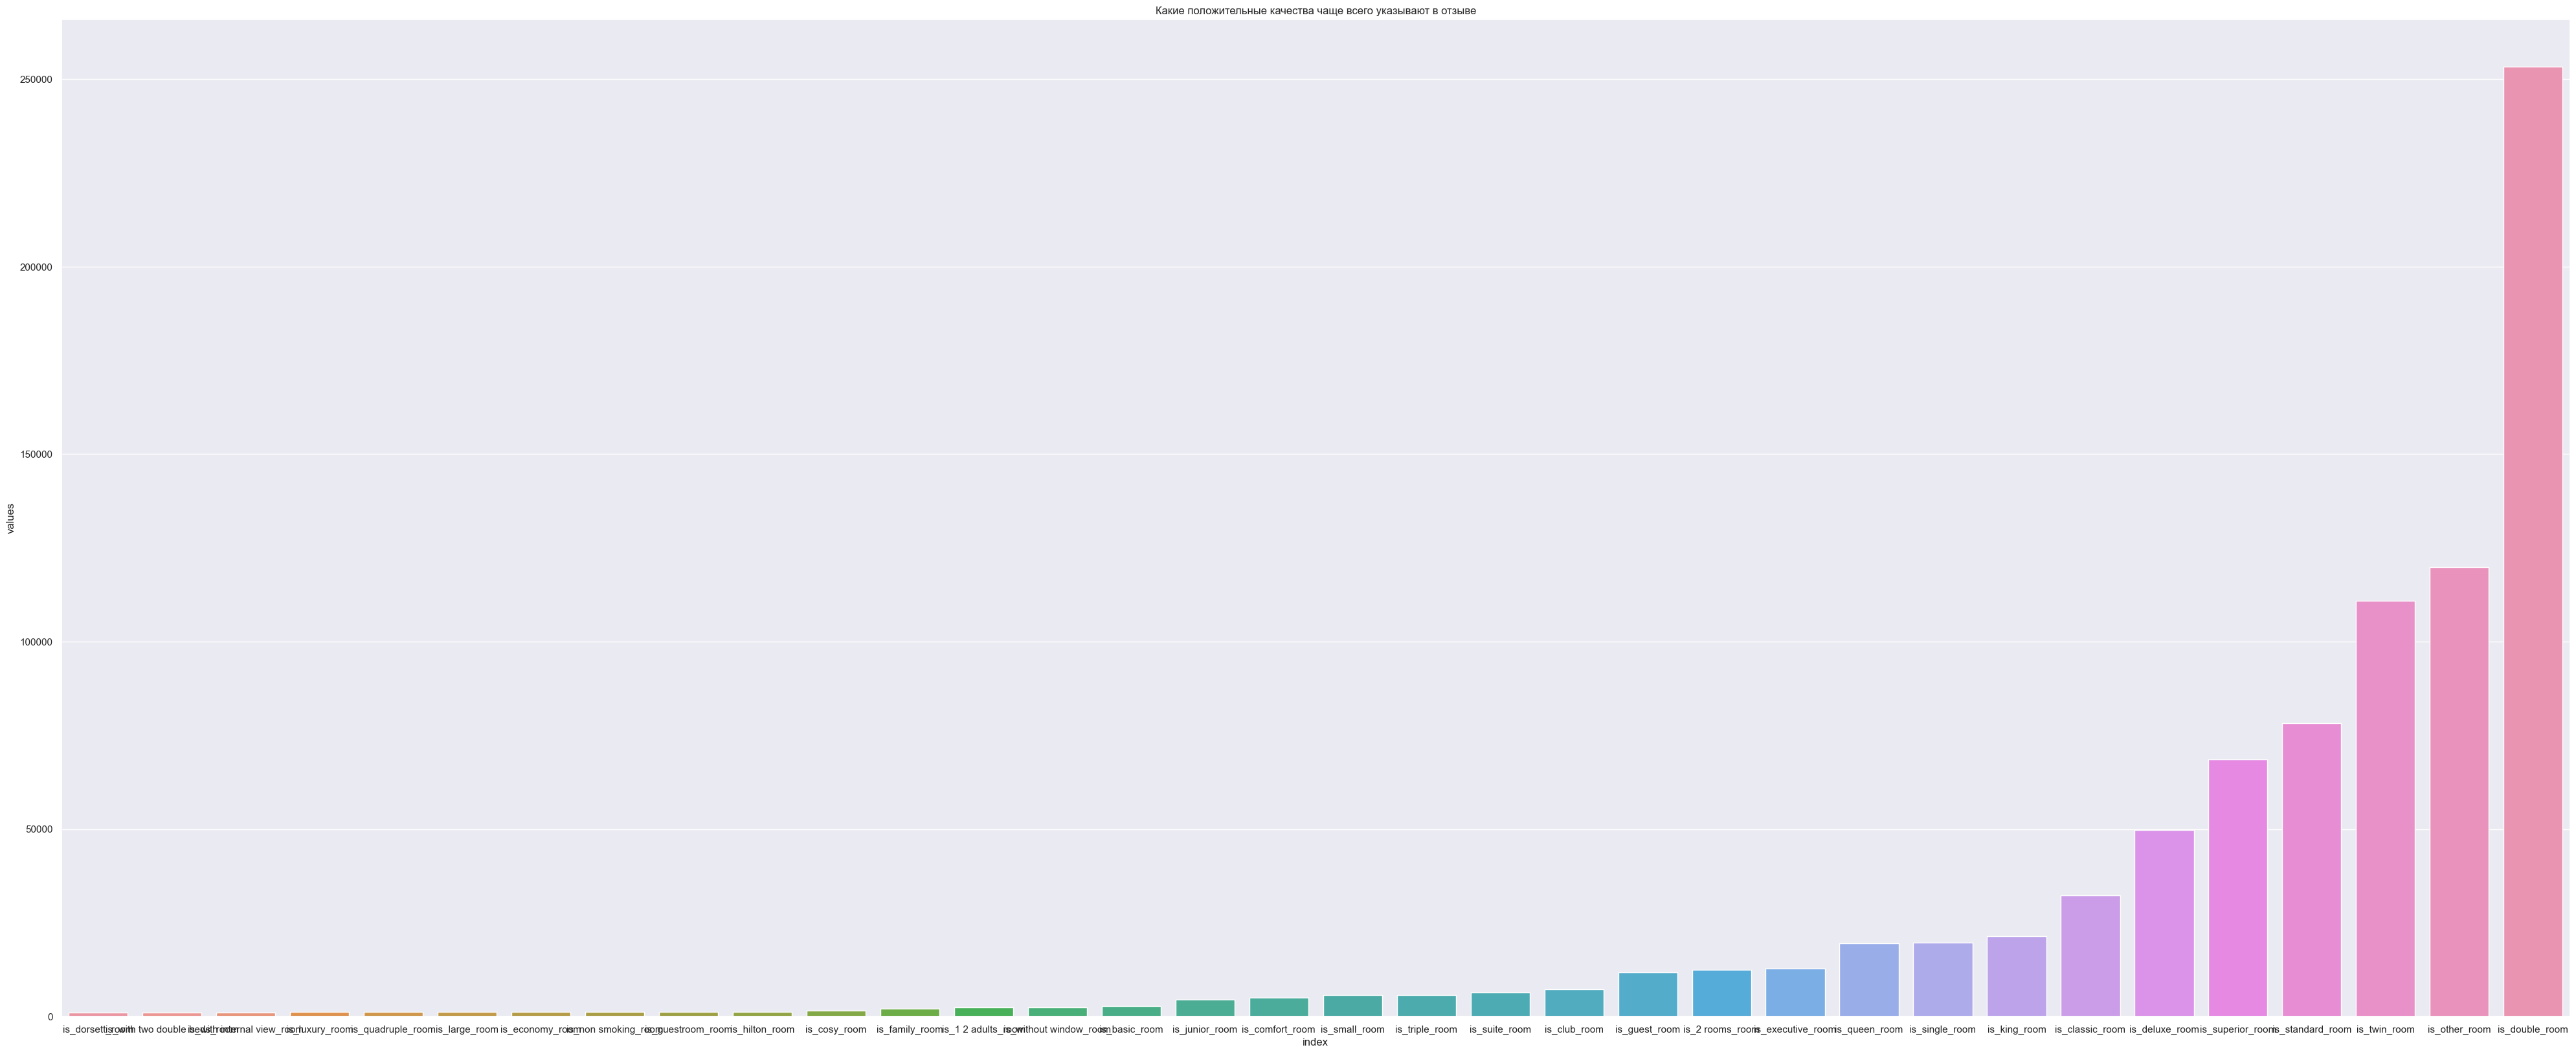

In [90]:
# Визуализация
sumdata = numdata[cs].sum().sort_values()

visdata = pd.DataFrame()
visdata['index'] = sumdata.index
visdata['values'] = sumdata.values

# График
plt.figure(figsize=(50, 20))

title = 'Какие положительные качества чаще всего указывают в отзыве'
sns.barplot(data=visdata, x='index', y='values', n_boot=5).set_title(title)

*Тут сложно различить, но тем не менее, наибольшей популярностью пользуются двойные комнаты, так как большинство постояльцев - это пары. Уже меньшей популярностью пользуются либо стандартные номера, вероятно для бизнес-поездок коих не так много, либо наоборот номера высокого класса, которые намного дороже. Все остальные типы комнат можно смело записывать в "другие", так как они встречаются очень редко и по количеству несравнимы с вышеперечисленными.*

In [91]:
for col in numdata.columns:
    if ('is_' in col) and ('_room' in col):
        catcols += [col]
        
catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing',
 'bad_all',
 'bad_breakfast',
 'bad_everything',
 'bad_expensive',
 'bad_location',
 'bad_nothing',
 'bad_parking',
 'bad_pillows',
 'bad_price',
 'bad_room',
 'bad_size',
 'bad_staff',
 'bad_wifi',
 'trip_type',
 'with_pets',
 'from_mobile',
 'trav_type',
 'is_double_room',
 'is_standard_room',
 'is_superior_room',
 'is_deluxe_room',
 'is_twin_room',
 'is_classic

In [92]:
numdata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 94 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

---

### Признаки `'review_total_positive_word_counts'` и `'review_total_negative_word_counts'`

От количетва слов в отзыве зависит то, насколько отзыв информативен, насколько рецензент обращает внимание на детали, а значит наиболее информативный отзыв наилучшим образом обосновывает оценку.

In [93]:
# Чтобы рассчитать реальную разницу в количестве слов, 
# лучше эти показатели нормализовать с помощью мин-макс-шкалирования
scaler = MinMaxScaler()

positive = numdata['review_total_positive_word_counts']
negative = numdata['review_total_negative_word_counts']

numdata['positive_norm'] = scaler.fit_transform(pd.DataFrame(positive))
numdata['negative_norm'] = scaler.fit_transform(pd.DataFrame(negative))

# Разница
numdata['positive_negative_diff'] = numdata['positive_norm'] - numdata['negative_norm']

# Флажок, указывающий на в основном позитивный отзыв, иначе - в основном негативный
numdata['mostly_positive'] = numdata['positive_negative_diff'].apply(lambda x: 1 if x > 0 else 0)

# Количество слов вообще и пропорция позитивного и негативного
numdata['review_total_word_counts'] = positive + negative
numdata['positive_proportion'] = (positive / numdata['review_total_word_counts']).fillna(0.5)

In [94]:
cols = ['positive_norm', 'negative_norm', 'positive_negative_diff', 
        'mostly_positive', 'review_total_word_counts', 'positive_proportion']

numdata[cols] 

,positive_norm,negative_norm,positive_negative_diff,mostly_positive,review_total_word_counts,positive_proportion
0,0.010127,0.007353,0.002774,1,7,0.571429
1,0.005063,0.007353,-0.002290,0,5,0.400000
2,0.000000,0.014706,-0.014706,0,6,0.000000
3,0.027848,0.000000,0.027848,1,11,1.000000
4,0.050633,0.009804,0.040829,1,24,0.833333
...,...,...,...,...,...,...
515733,0.010127,0.000000,0.010127,1,4,1.000000
515734,0.060759,0.000000,0.060759,1,24,1.000000
515735,0.058228,0.075980,-0.017753,0,54,0.425926
515736,0.050633,0.000000,0.050633,1,20,1.000000


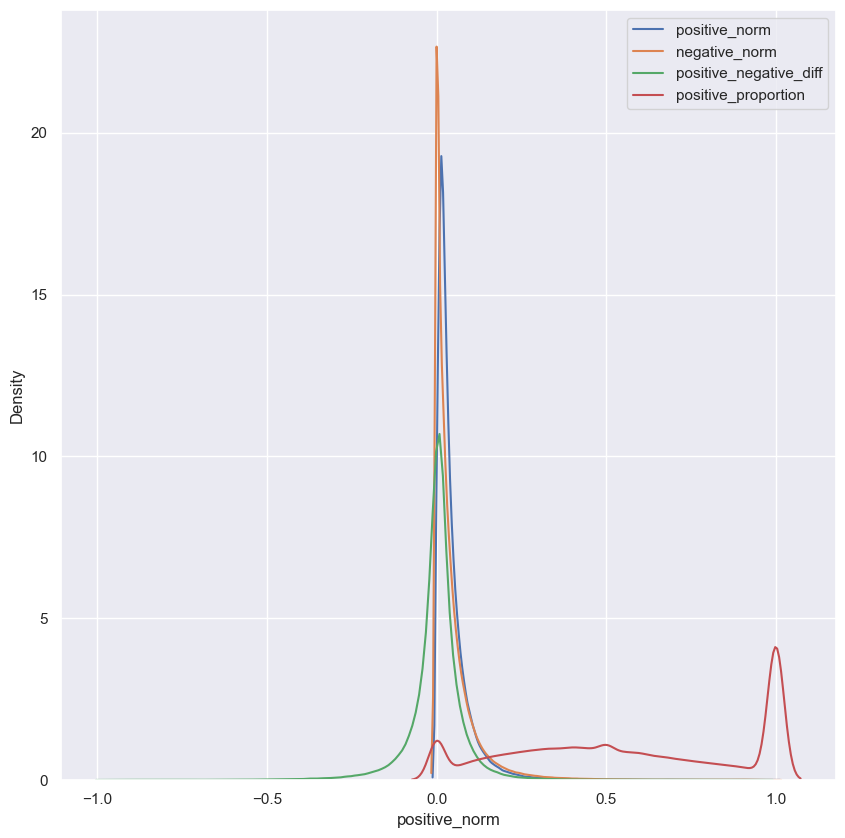

In [95]:
# Визуализация распределения позитивных и негативных отзывов
plt.figure(figsize=(10, 10))

for c in cols:
    if numdata[c].dtypes == 'float':
        sns.kdeplot(numdata[c], label=c)

plt.legend()

*Поскольку количество положительных и отрицательных слов в отзыве нормализованы способом MinMaxScaler, то они разбросаны в диапазоне от 0 до 1. Однако большая часть значений сконцентрирована около нуля, что говорит о большом количестве выбросов. Что касаестя их разницы, она распределена относительно нормально от -1 до 1. А распределение пропорции довольно интересное, большая часть около 1, а далее идет "горб" к нулю. С чем это связано, я не знаю.*

In [96]:
numcols += ['positive_norm', 'negative_norm', 'positive_negative_diff', 
            'review_total_word_counts', 'positive_proportion']

numcols

['additional_number_of_scoring',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'stayed_nights',
 'positive_norm',
 'negative_norm',
 'positive_negative_diff',
 'review_total_word_counts',
 'positive_proportion']

In [97]:
catcols += ['mostly_positive']

catcols

['average_score',
 'hotel_city',
 'review_month',
 'is_hot_season',
 'review_dayofweek',
 'is_weekend',
 'the_hotel_0',
 'the_hotel_1',
 'the_hotel_2',
 'the_hotel_3',
 'the_hotel_4',
 'the_hotel_5',
 'the_hotel_6',
 'total_number_of_reviews_reviewer_has_given',
 'is_resident_reviewer',
 'is_european_reviewer',
 'is_asian_reviewer',
 'is_american_reviewer',
 'is_other_reviewer',
 'is_there_positive',
 'is_there_negative',
 'good_all',
 'good_bed',
 'good_breakfast',
 'good_clean',
 'good_everything',
 'good_hotel',
 'good_location',
 'good_position',
 'good_room',
 'good_service',
 'good_staff',
 'good_view',
 'good_nothing',
 'bad_all',
 'bad_breakfast',
 'bad_everything',
 'bad_expensive',
 'bad_location',
 'bad_nothing',
 'bad_parking',
 'bad_pillows',
 'bad_price',
 'bad_room',
 'bad_size',
 'bad_staff',
 'bad_wifi',
 'trip_type',
 'with_pets',
 'from_mobile',
 'trav_type',
 'is_double_room',
 'is_standard_room',
 'is_superior_room',
 'is_deluxe_room',
 'is_twin_room',
 'is_classic

In [98]:
numdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 100 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  


----

## Очистка данных

Преобразование и генерация признаков завершена. Теперь нужно очистить данные от строк и столбцов, которые будут мешать обучению модели. Это дубликаты, выбросы, сильно коррелирующие между собой признаки и прочее.

In [99]:
# Теперь в качестве основного датасета используем числовой датасет
# со всеми закодированными текстовыми признаками
data = numdata.copy() 

data.shape[0]

515738

### Удаление дубликатов

In [100]:
# Для начала узнаем, сколько дубликатов содердит наш датасет
dupdata = data.duplicated(subset=data.columns.tolist())

dupdata.value_counts()

False    515397
True        341
dtype: int64

In [101]:
# Удаляем 341 дубликат
data = data.drop_duplicates().reset_index(drop=True)

data.shape[0]

515397

### Удаление выбросов

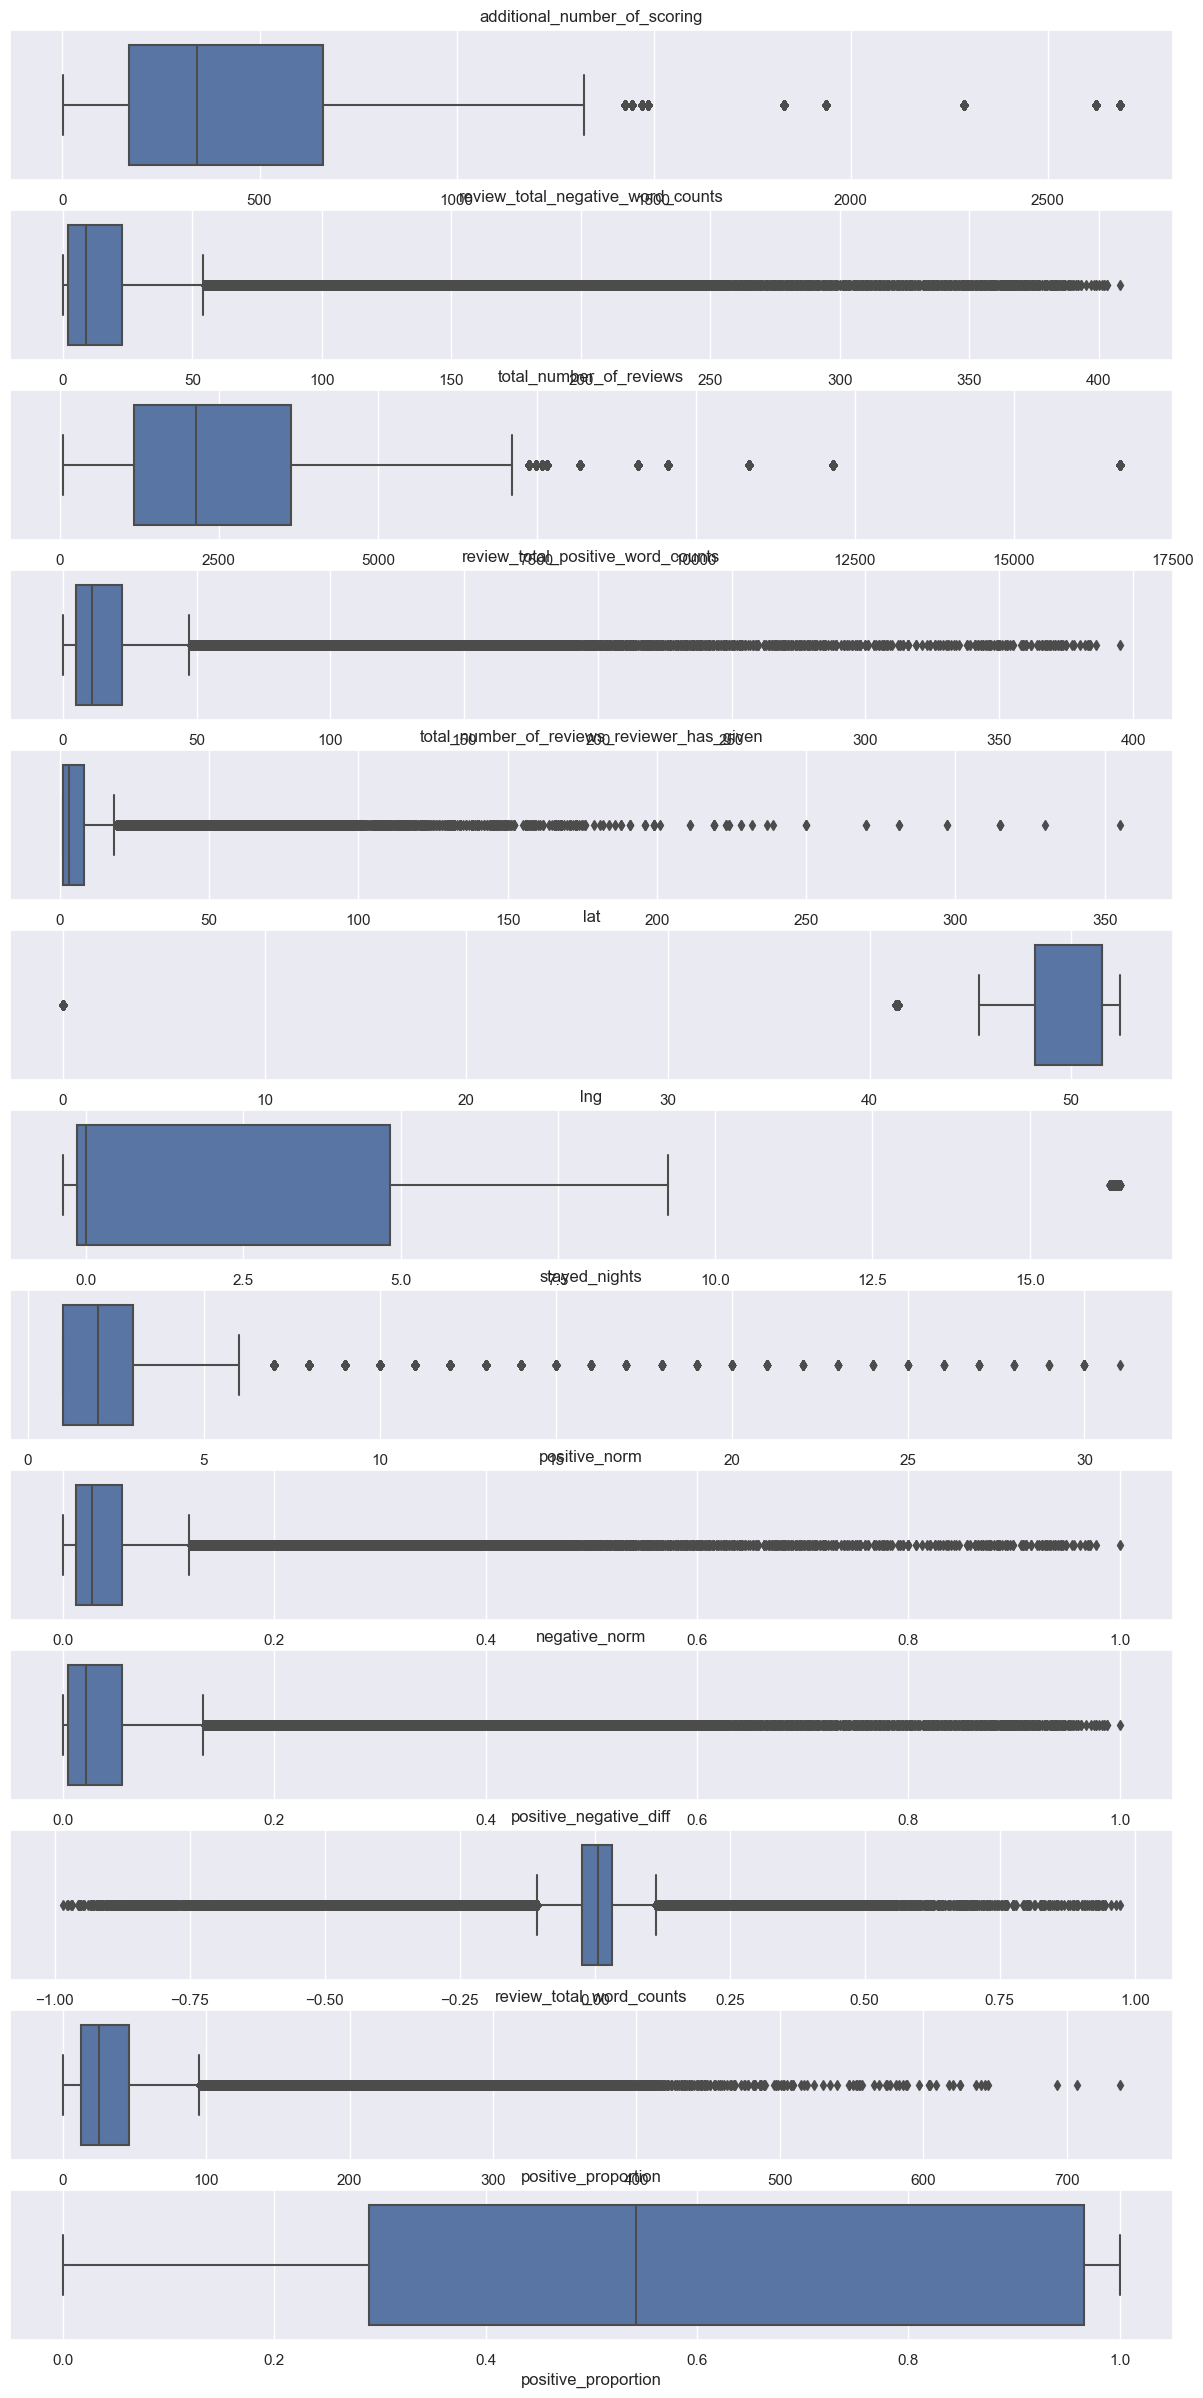

In [102]:
# Теперь посмотрим, как распределены непрерывные признаки, чтобы найти выбросы в них
visdata = data[numcols]

# График
fig, ax = plt.subplots(nrows=visdata.shape[1], 
                       ncols=1, 
                       figsize=(15,30))

for i, col in enumerate(visdata.columns):
    sns.boxplot(data=visdata, x=col, ax=ax[i]).set_title(col)

*Многие признаки действительно демонстрируют большое количество выбросов. Все признаки, связанные с количеством слов, потому что все пишут отзывы по разному. Точно также признаки о количестве отзывов, так как все пишут их в разном количестве.*

In [103]:
# Попробуем их очистить с помощью особой функции

def find_outliers(data, feature, left=3, right=3, log_scale=False):
    """Находит выбросы в данных, используя метод 3 сигм."""
    
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return cleaned

In [104]:
# Чтобы не расписывать одно и то же на кучу строк, воспользуемся циклом по столбцам,
# а для этого присвоим датасету новое название и запустим его в цикл
data_cld = data.copy()

for col in data[numcols].columns:
    data_cld = find_outliers(data_cld, col, log_scale=True)

In [105]:
# Датасет существенно сократился по строкам
data_cld.shape[0] 

476571

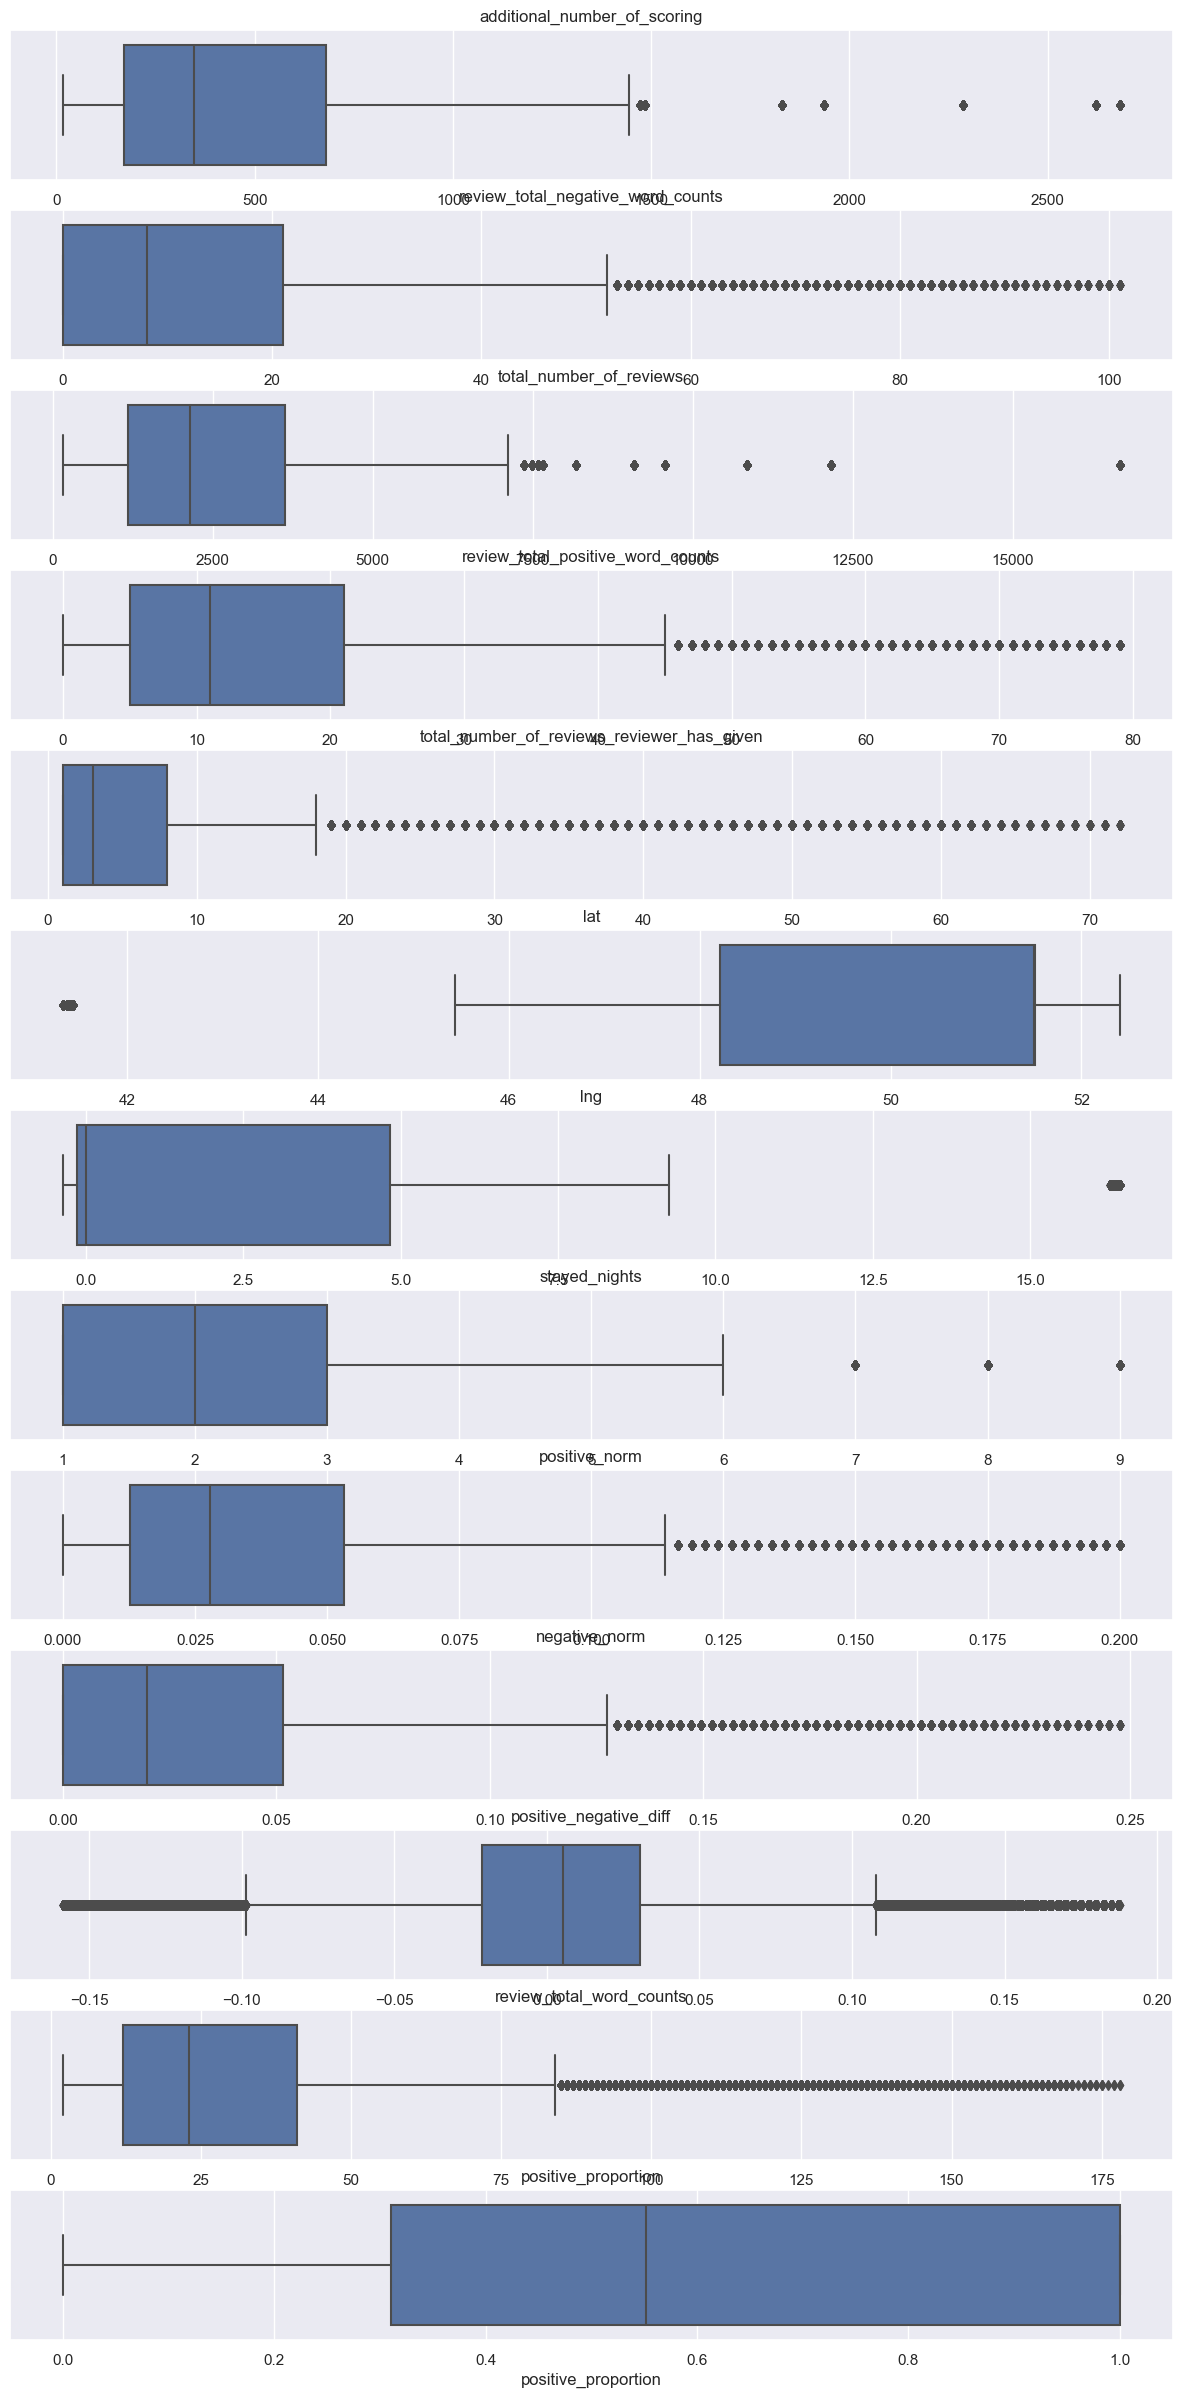

In [106]:
# Теперь посмотрим на распределение уже после очистки
visdata = data_cld[numcols]

fig, ax = plt.subplots(nrows=visdata.shape[1], 
                       ncols=1, 
                       figsize=(15,30))

for i, col in enumerate(visdata.columns):
    sns.boxplot(data=visdata, x=col, ax=ax[i]).set_title(col)

*Как видим, несмотря на то что выбросы все еще остаются, их уже намного меньше и распределение уже совершенно другое.*

---

## Отбор признаков

In [107]:
# Наш основной датасет теперь очищен, возьмемся за столбцы
data = data_cld.copy()

data.shape[1]

100

### Проверка на мультиколлинеарность

Как известно, мультиколлинеарность сильно мешает модели, поэтому данные нужно проверить на такие признаки.

<AxesSubplot: >

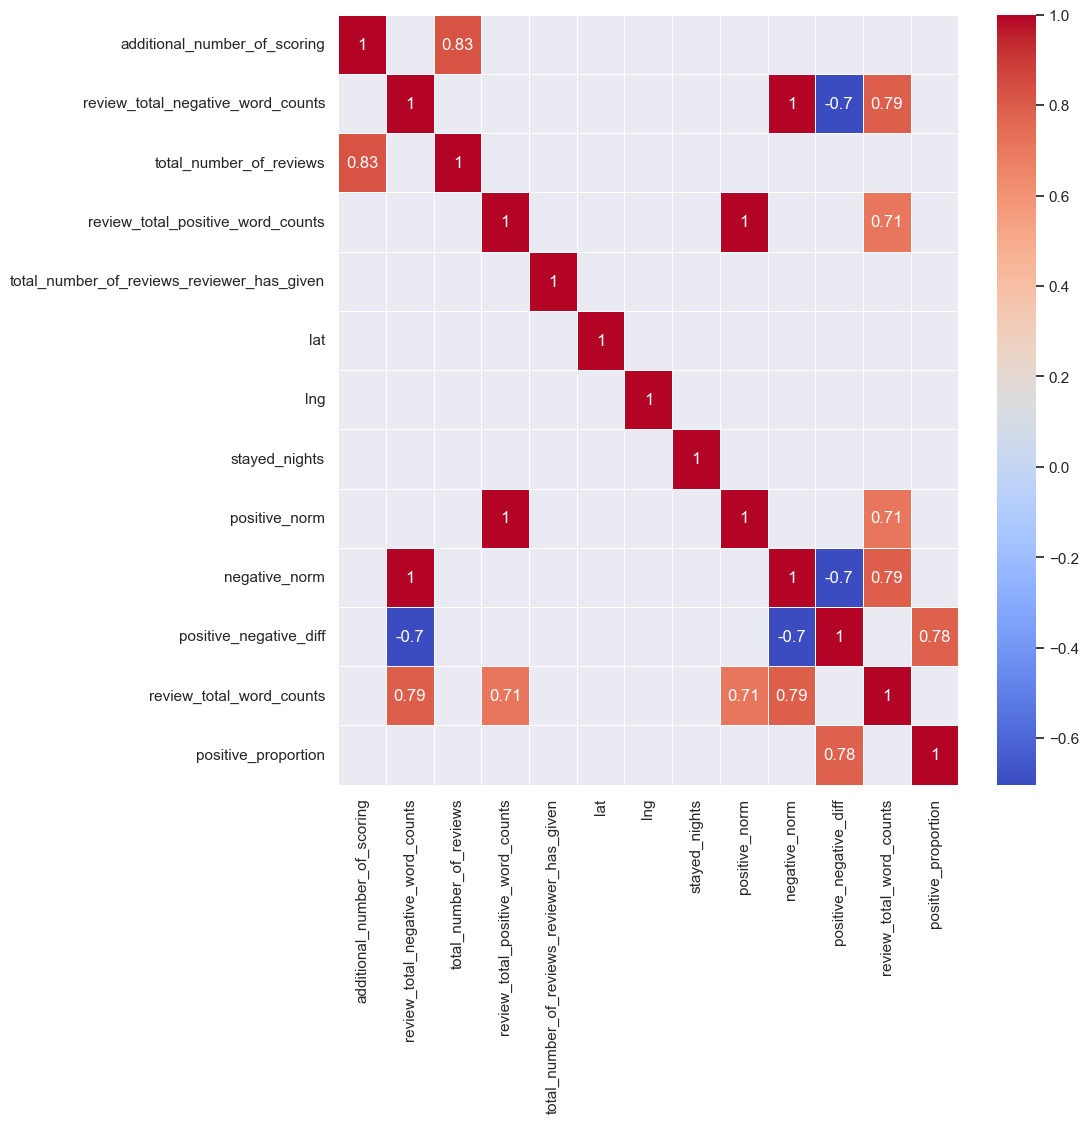

In [108]:
# Для непрерывных признаков используем метод Пирсона
datacorr = data[numcols].corr(method='pearson')

# График
plt.figure(figsize=(10, 10)) 
sns.heatmap(data=datacorr[abs(datacorr) >= 0.7], 
            annot=True, 
            linewidths=.5, 
            cmap='coolwarm')

*Итак, наиболее сильную корреляцию показывают признаки `'positive_norm'` и `'negative_norm'`, так как по сути являются точными копиями признаков, подсчитывающих положительные и отрицательные слова в отзывах, только в ином масштабе. Также `'total_number_of_reviews'` сильно коррелирует с `'additional_number_of_scoring'`, то есть их почти равное количество. Разница `'positive_negative_diff'` коррелирует с `'negative_norm'` и `'positive_proportion'`, то есть разница склоняется в отрицательную сторону. Общее количество `'review_total_word_counts'` коррелирует и с позитивной и с негативной нормой, так как это счетчик всех слов вместе.*

<AxesSubplot: >

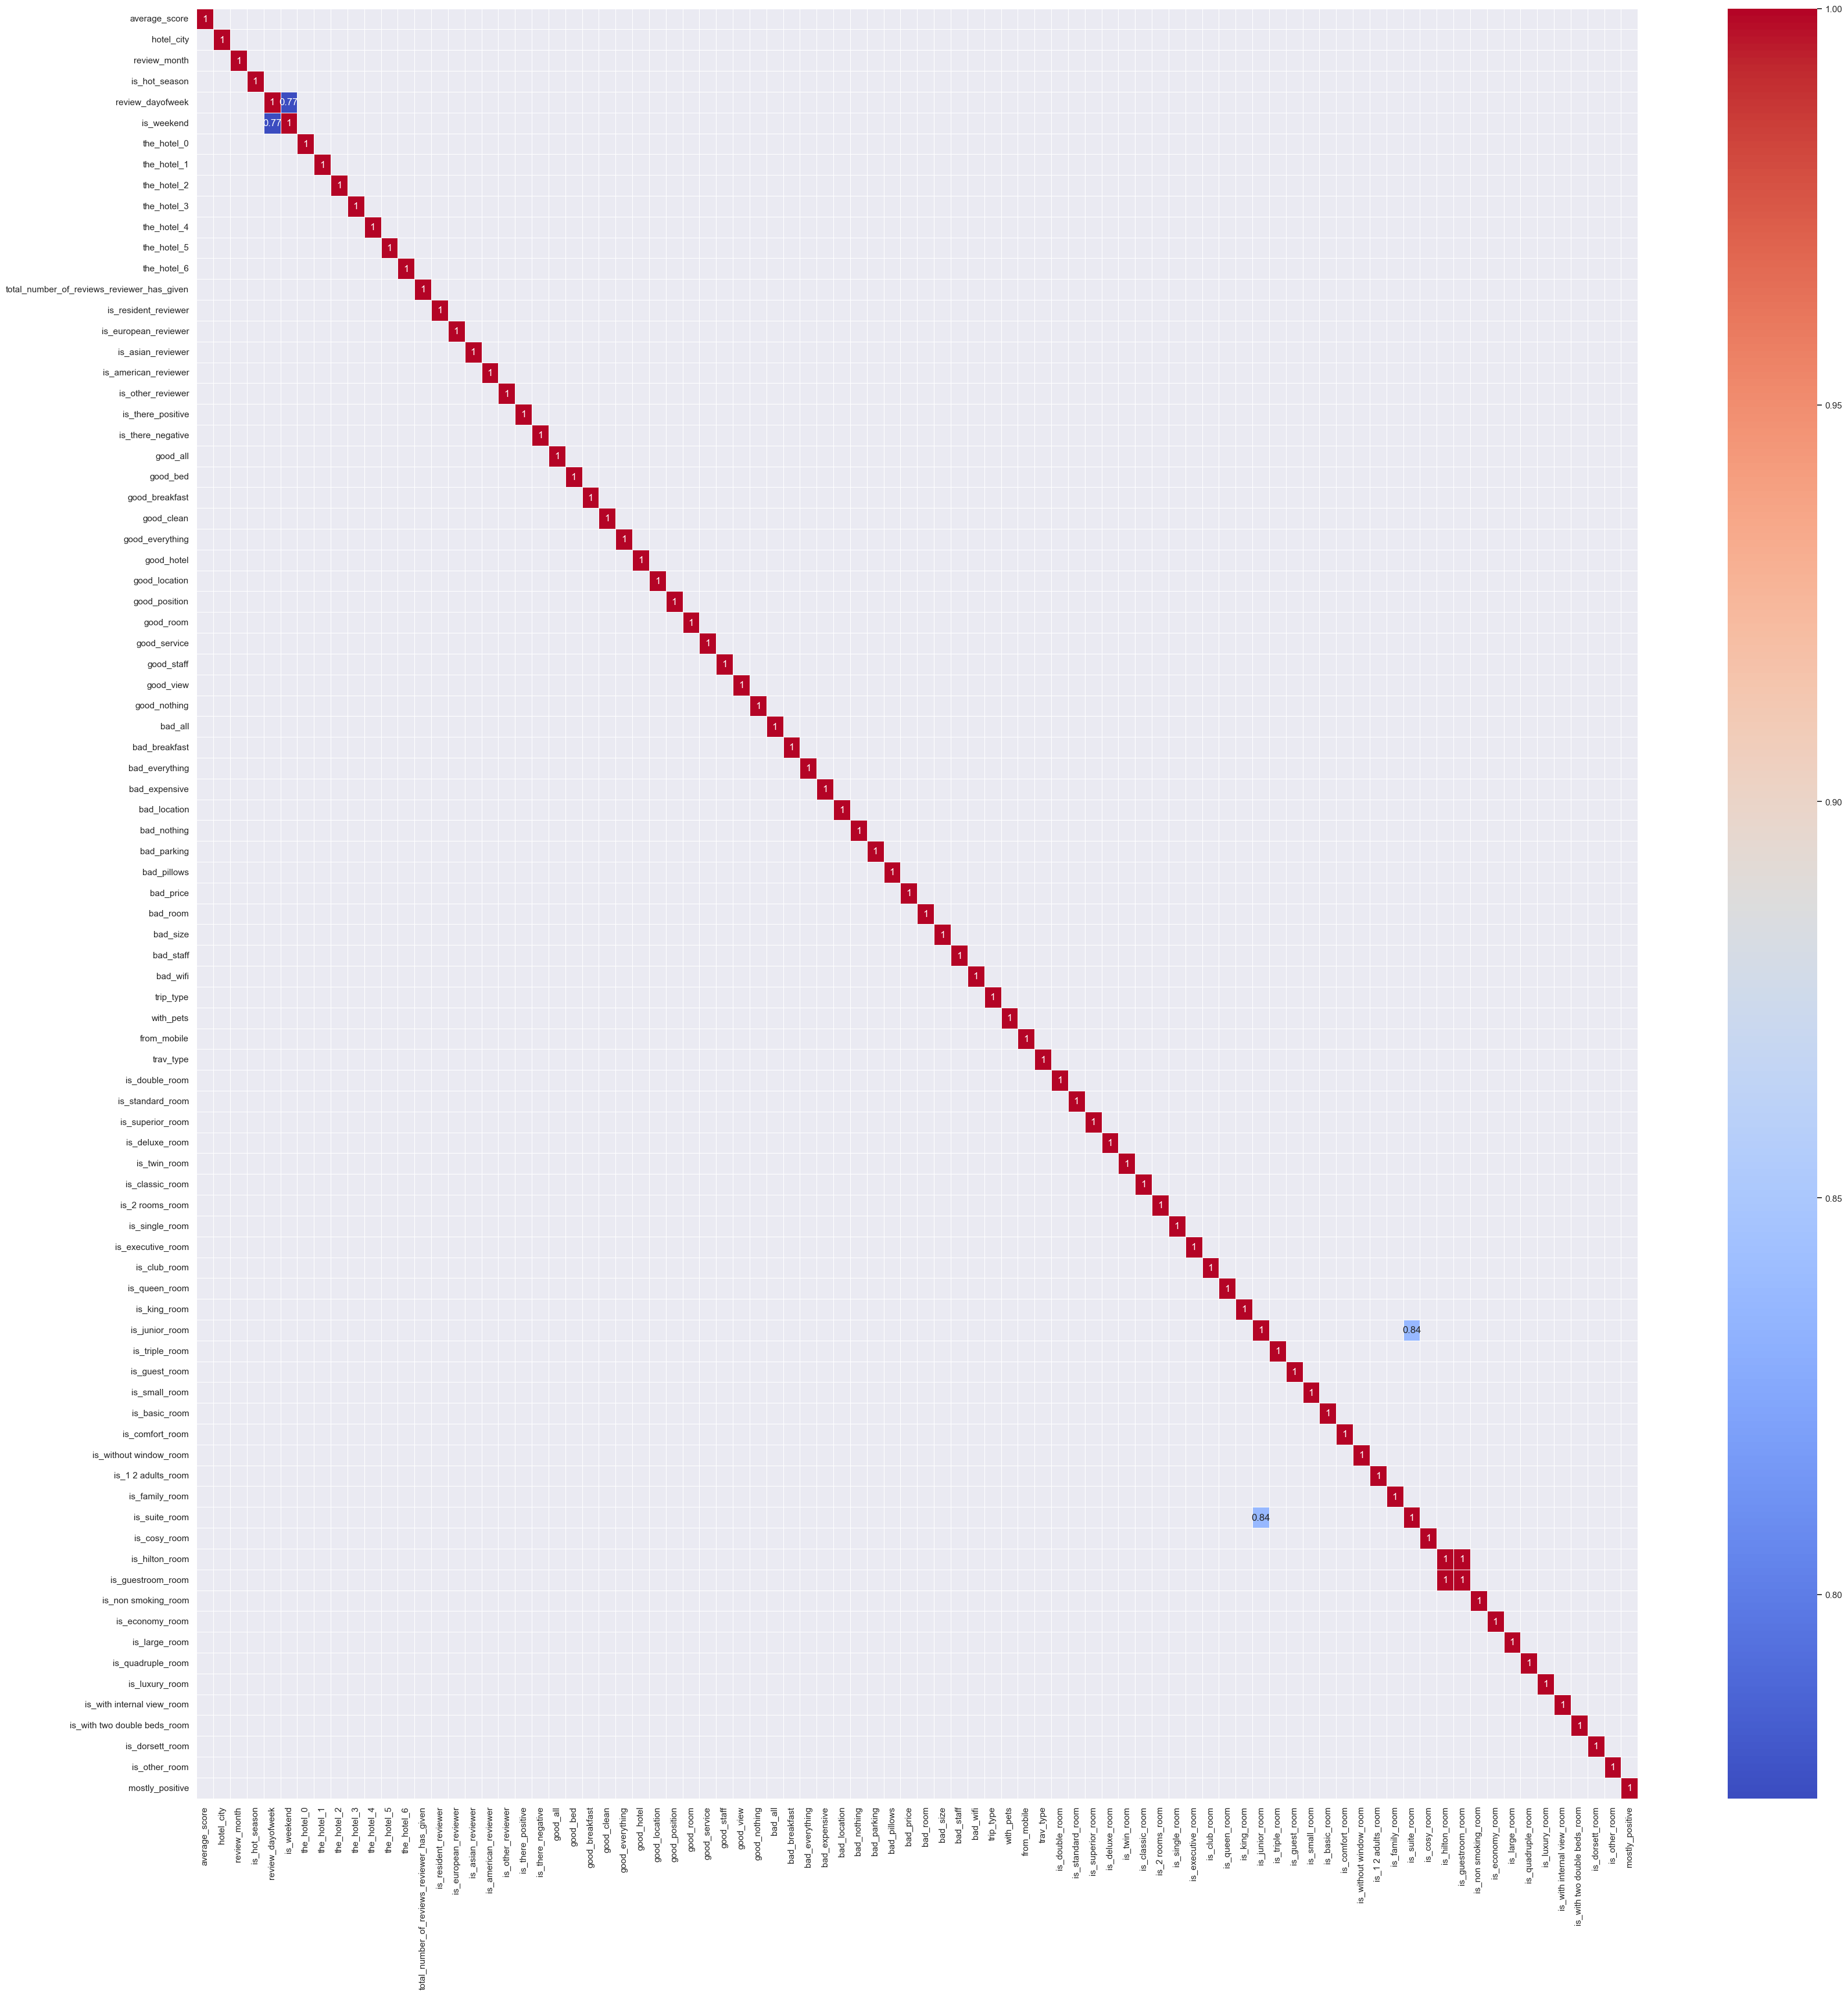

In [109]:
# Для категориальных признаков используется метод Спирмена
datacorr = data[catcols].corr(method='spearman')

# График
plt.figure(figsize=(40, 40))
sns.heatmap(data=datacorr[abs(datacorr) >= 0.7], 
            annot=True, 
            linewidths=.5, 
            cmap='coolwarm') 

*Удивительно, но на такой большой датасет, сильную корреляцию показывают всего 3 признака. День недели `'review_dayofweek'` коррелирует с `'is_weekend'`, что логично, ведь большинство людей путешествует на выходных (почему-то столбчатая диаграмма на момент создания этих признаков, не показала этого). Номера типа Сьют часто совпадают сномерами типа Джуниор, возможно потому что сьюты снимаются семьями с детьми и там есть комната для детей. И сто процентов номеров Хилтон - это номера типа Геструм, то есть у отелей Хилтон есть номера только такого типа.*

In [110]:
# Вот те колонки, которые показывают очень сильную корреляцию
mult_cols = ['total_number_of_reviews', 'positive_norm', 
             'negative_norm', 'positive_negative_diff', 
             'review_total_word_counts', 'positive_proportion', 
             'is_weekend', 'is_suite_room', 'is_guestroom_room'] 

### Проверка на статистическую значимость

Теперь нужно узнать, какие признаки будут наиболее важны для модели. Это можно сделать с помощью статистических тестов.

<AxesSubplot: >

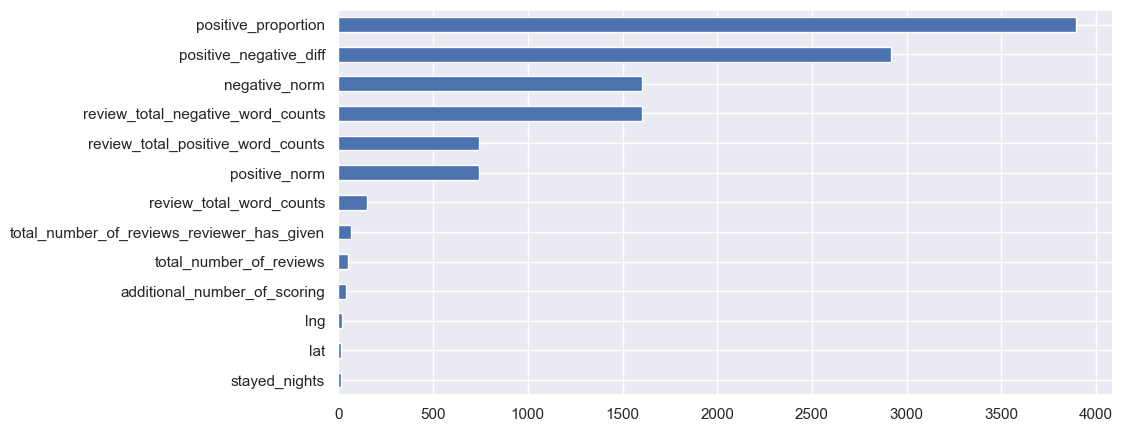

In [111]:
# Для непрерывных признаков будем использовать параметрический тест ANOVA
scorefunc = f_classif(X = data[numcols], 
                      y = data['reviewer_score'])

# Нам нужен только уровень значимости
imp_num = pd.Series(scorefunc[0], index=numcols).sort_values()

# График
plt.figure(figsize=(10, 5))
imp_num.plot(kind = 'barh')

<AxesSubplot: >

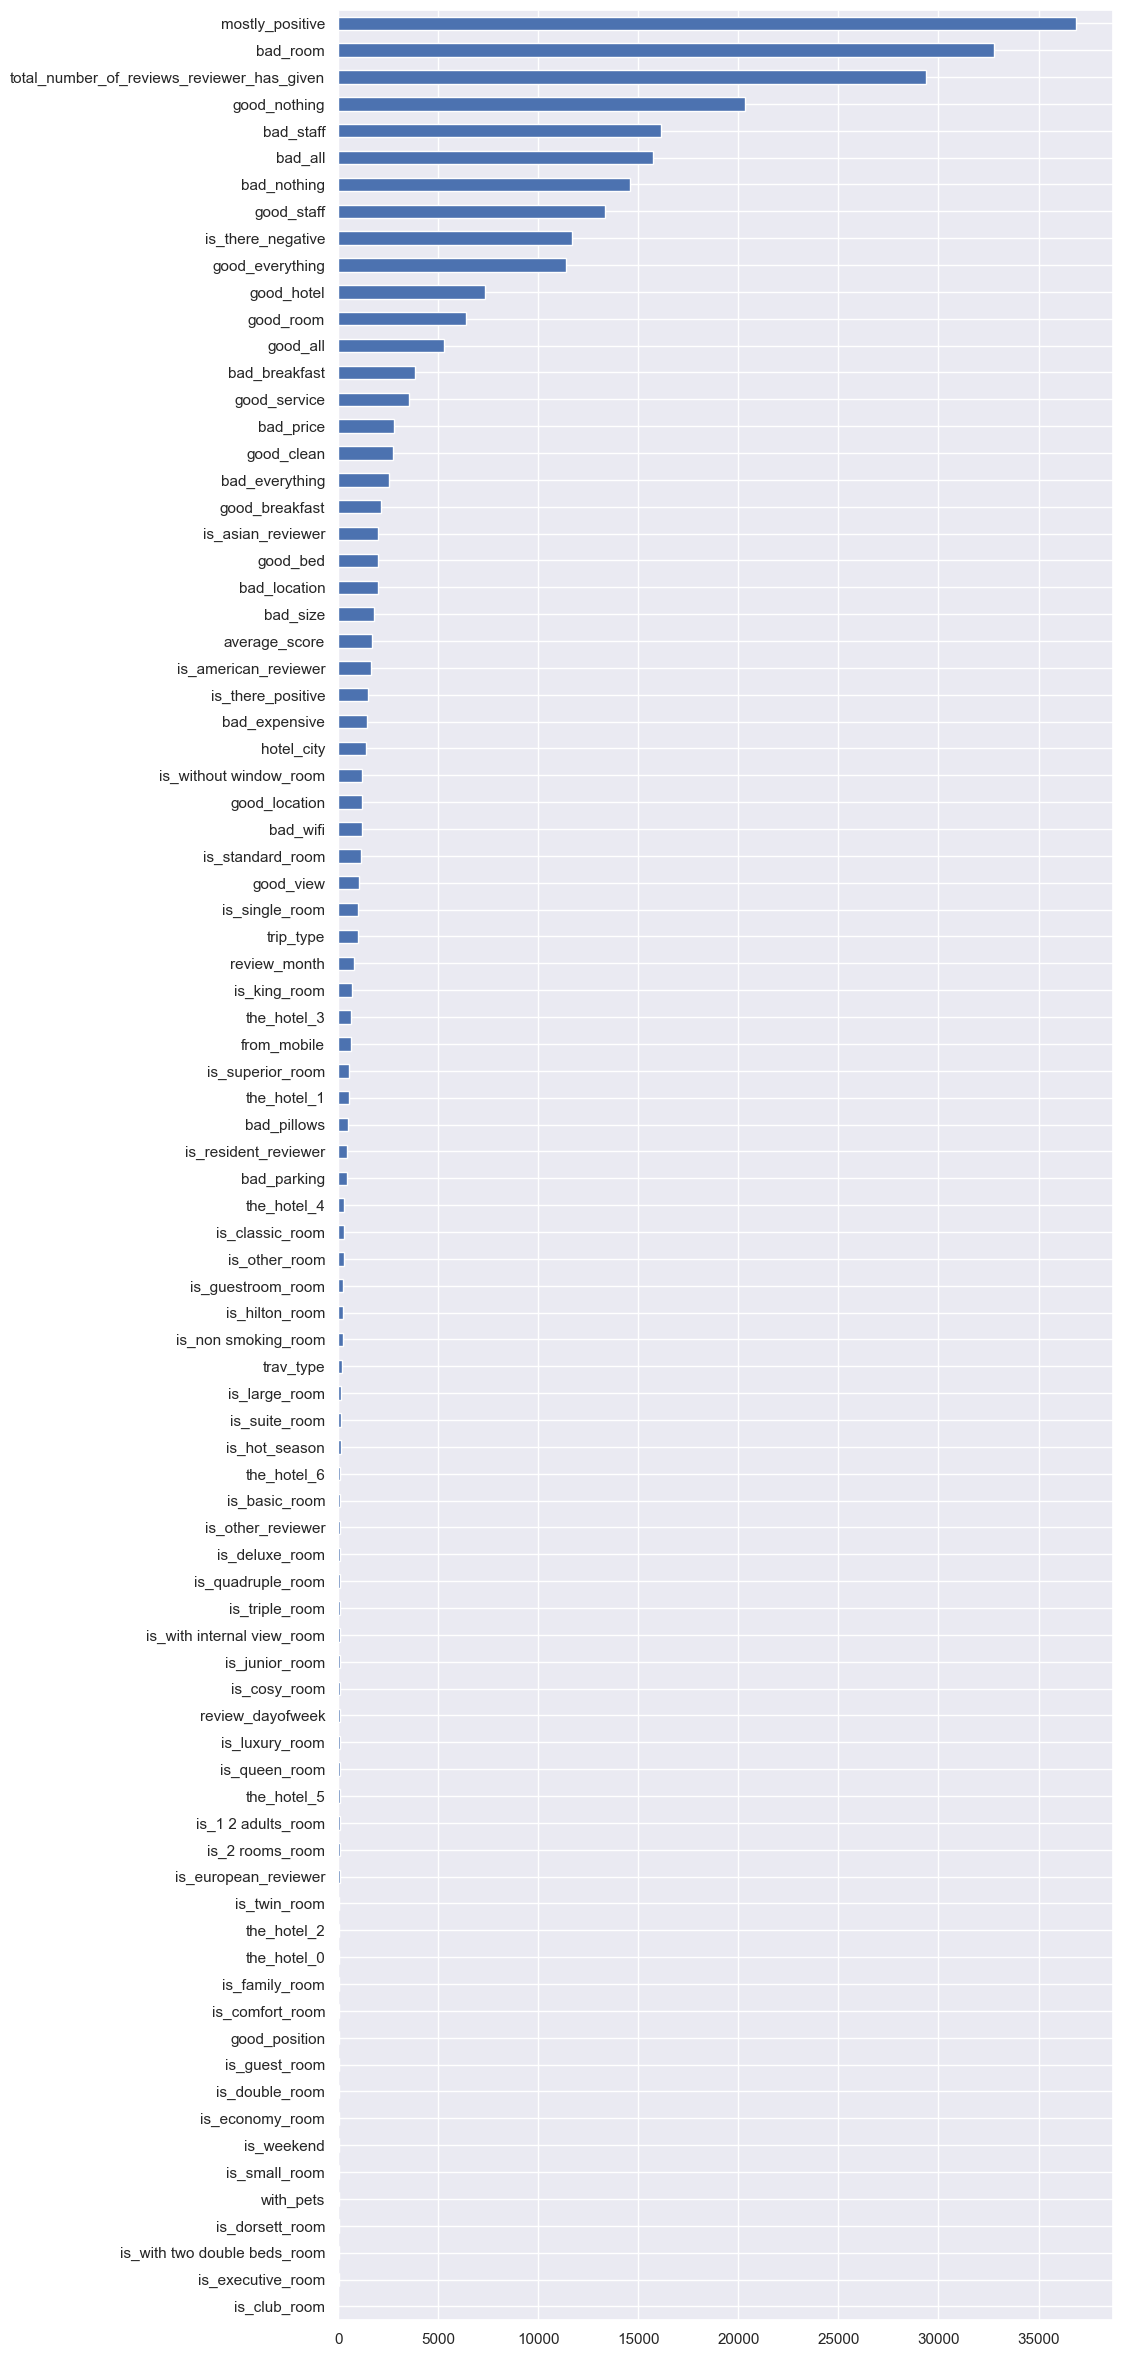

In [112]:
# Для категориальных признаков используется непараметрический тест Хи-квадрат
scorefunc = chi2(X = data[catcols], 
                 y = data['reviewer_score'].astype('int'))

imp_cat = pd.Series(scorefunc[0], index=catcols).sort_values()

# График
plt.figure(figsize=(10, 30))
imp_cat.plot(kind = 'barh')

In [113]:
# Отбираем признаки с уровнем значимости меньше 50
low_nums = imp_num[imp_num < 50].index.tolist() 
low_cats = imp_cat[imp_cat < 50].index.tolist()

low_cols = low_nums + low_cats

low_cols

['stayed_nights',
 'lat',
 'lng',
 'additional_number_of_scoring',
 'is_club_room',
 'is_executive_room',
 'is_with two double beds_room',
 'is_dorsett_room',
 'with_pets',
 'is_small_room',
 'is_weekend',
 'is_economy_room',
 'is_double_room',
 'is_guest_room',
 'good_position',
 'is_comfort_room',
 'is_family_room',
 'the_hotel_0']

In [114]:
# Как показывала практика, удаление "незначимых" признаков 
# негативно влияет на показатель МАPЕ, то есть модель больше ошибается, 
# поэтому лучше удалить только мультиколлинеарные признаки

data = data.drop(mult_cols, axis=1) 

data.shape[1]

91

---

## Обучение машины

In [115]:
# Выделим тренировочную и тестовую части
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data['reviewer_score'] # наш таргет

# Выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

# Проверяем размерность
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

((357463, 90), (119108, 90), (357463, 89), (285970, 89), (71493, 89))

In [116]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ) 
model = RandomForestRegressor(n_estimators=100, 
                              verbose=1, 
                              n_jobs=-1, 
                              random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


---

## Оценка качества модели

In [117]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# и смотрим насколько они в среднем отличаются.
# Метрика называется Mean Absolute Error (MAE) и 
# показывает среднее отклонение предсказанных значений от фактических.

mae = metrics.mean_absolute_error(y_test, y_pred)

print('MAE:', round(mae, 4))

MAE: 0.87


In [118]:
# Но нам нужен процентаж а не голый коэффициент среднего отклонения,
# поэтому нам нужна функция, которая его высчитывает

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return round(mape, 2)

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred), '%')

MAPE: 12.32 %


## <center> Что можно сказать в итоге?
    
    Показатель MAPE без обработок и преобразований был около 13.5%, нам нужно было снизить этот показатель. И мы его действительно снизили! Теперь он равен примерно 12.32%, что на 1.18 процентов меньше. Вполне возможно было бы снизить этот показатель еще сильнее, использовать еще какие-то инструменты, но я не стал мудрить и использовал только то, что знаю сам на данный момент. На мой взгляд, я добился вполне неплохого результата.

---

# САБМИШШЕН

In [119]:
predict_submission = model.predict(test_data.drop(['reviewer_score'], axis=1))

predict_submission = pd.Series(predict_submission)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


In [120]:
predict_submission

0         8.811
1         6.743
2         7.888
3         9.859
4         9.504
          ...  
119103    9.059
119104    9.011
119105    8.244
119106    9.694
119107    7.277
Length: 119108, dtype: float64

In [121]:
sample_submission['reviewer_score'] = predict_submission

fill = {'reviewer_score': sample_submission['reviewer_score'].mean()}
sample_submission = sample_submission.fillna(fill)

sample_submission

,reviewer_score,id
0,8.811000,488440
1,6.743000,274649
2,7.888000,374688
3,9.859000,404352
4,9.504000,451596
...,...,...
128930,8.426357,495812
128931,8.426357,315577
128932,8.426357,511968
128933,8.426357,303386


In [122]:
sample_submission.to_csv('submission.csv', index=False)

---